<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/Autoencoder_newdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import glob, re
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.signal import welch, csd, coherence, stft
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [120]:
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')

# # In case I want to train with challenge dataset
# os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')
# background_train = np.load('background_train.npy')
# # stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
# # background_train = background_train/stds_train
# background_train = np.swapaxes(background_train, 1, 2)

# background_test = np.load('background_test.npy')
# # stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
# # background_test = background_test/stds_test
# background_test = np.swapaxes(background_test, 1, 2)

# In case I want to train with Argyro's dataset
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')
# Load data and normalize it
background = np.load('O3_Background_dataset.npz')

background_train = background['data'][:-1024]
# stds = np.std(background_train, axis=-1)[:, :, np.newaxis]
# background_train = background_train/stds
background_train = np.swapaxes(background_train, 1, 2)

background_test = background['data'][-1024:]
# stds = np.std(background_test, axis=-1)[:, :, np.newaxis]
# background_test = background_test/stds
background_test = np.swapaxes(background_test, 1, 2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')
# Load signal data
signal = np.load('O3_rescaled_signals_dataset.npz')
snr = signal['snr']
seven = np.where(snr>7)

# load"SineGaussian","BBH","Gaussian","Cusp","Kink","KinkKink","WhiteNoiseBurst"
signal_label = signal['label']

SG_index = np.where(signal_label == 2)
SG_index = np.intersect1d(SG_index, seven)
SG = signal['data'][SG_index]
# stds = np.std(SG, axis=-1)[:, :, np.newaxis]
# SG = SG/stds
SG = np.swapaxes(SG, 1, 2)

BBH_index = np.where(signal_label == 3)
BBH_index = np.intersect1d(BBH_index, seven)
BBH = signal['data'][BBH_index]
# stds = np.std(BBH, axis=-1)[:, :, np.newaxis]
# BBH = BBH/stds
BBH = np.swapaxes(BBH, 1, 2)

Gaussian_index = np.where(signal_label == 4)
Gaussian_index = np.intersect1d(Gaussian_index, seven)
Gaussian = signal['data'][Gaussian_index]
# stds = np.std(Gaussian, axis=-1)[:, :, np.newaxis]
# Gaussian = Gaussian/stds
Gaussian = np.swapaxes(Gaussian, 1, 2)

Cusp_index = np.where(signal_label == 5)
Cusp_index = np.intersect1d(Cusp_index, seven)
Cusp = signal['data'][Cusp_index]
# stds = np.std(Cusp, axis=-1)[:, :, np.newaxis]
# Cusp = Cusp/stds
Cusp = np.swapaxes(Cusp, 1, 2)

Kink_index = np.where(signal_label == 6)
Kink_index = np.intersect1d(Kink_index, seven)
Kink = signal['data'][Kink_index]
# stds = np.std(Kink, axis=-1)[:, :, np.newaxis]
# Kink = Kink/stds
Kink = np.swapaxes(Kink, 1, 2)

KinkKink_index = np.where(signal_label == 7)
KinkKink_index = np.intersect1d(KinkKink_index, seven)
KinkKink = signal['data'][KinkKink_index]
# stds = np.std(KinkKink, axis=-1)[:, :, np.newaxis]
# KinkKink = KinkKink/stds
KinkKink = np.swapaxes(KinkKink, 1, 2)

WNB_index = np.where(signal_label == 8)
WNB_index = np.intersect1d(WNB_index, seven)
WNB = signal['data'][WNB_index]
# stds = np.std(WNB, axis=-1)[:, :, np.newaxis]
# WNB = WNB/stds
WNB = np.swapaxes(WNB, 1, 2)

In [122]:
print('shape for background train/test' , background_train.shape, background_test.shape)
print('shape for SG ' , SG.shape)
print('shape for BBH ' , BBH.shape)
print('shape for Gaussian ' , Gaussian.shape)
print('shape for Cusp ' , Cusp.shape)
print('shape for Kink ' , Kink.shape)
print('shape for KinkKink ' , KinkKink.shape)
print('shape for WNB ' , WNB.shape)

shape for background train/test (254976, 200, 2) (1024, 200, 2)
shape for SG  (838, 200, 2)
shape for BBH  (840, 200, 2)
shape for Gaussian  (858, 200, 2)
shape for Cusp  (863, 200, 2)
shape for Kink  (843, 200, 2)
shape for KinkKink  (828, 200, 2)
shape for WNB  (843, 200, 2)


In [123]:
# Making correlation
def add_correlation_channel(x):
    x1, x2 = x[:, :, 0], x[:, :, 1]
    corr = np.array([
        np.correlate(x1[i], x2[i], mode='same') for i in range(x.shape[0])
    ])
    return np.stack([x1, x2, corr], axis=-1)

background_train = add_correlation_channel(background_train)
background_test = add_correlation_channel(background_test)
SG = add_correlation_channel(SG)
BBH = add_correlation_channel(BBH)
Gaussian = add_correlation_channel(Gaussian)
Cusp = add_correlation_channel(Cusp)
Kink = add_correlation_channel(Kink)
KinkKink = add_correlation_channel(KinkKink)
WNB = add_correlation_channel(WNB)

SOLUTION GIVEN

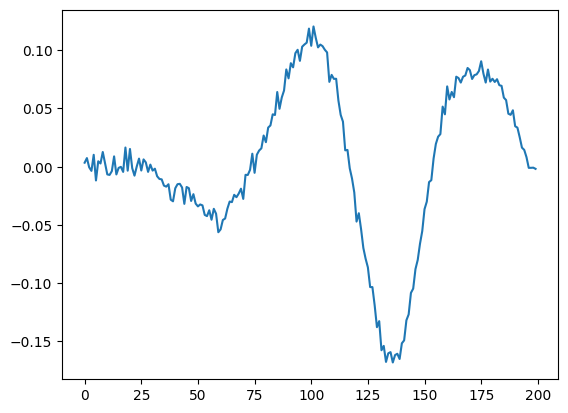

In [124]:
plt.plot(KinkKink[20,:,-1])

In [125]:

tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200,3),stft_shape=(6,41), dropout=0.1, batch_size = 256, epochs = 50, lr = 1e-3,
                 f1=3,f2=16,f3=32,f4=64,k1=16,k2=32,k3=64,k4=128,s1=2,s2=2,s3=1,s4=1):
        super().__init__()
        self.input_shape = input_shape
        self.stft_shape = stft_shape
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.f4 = f4
        self.k4 = k4
        self.s4 = s4
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model_ = None

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Encoder
        print('Encoder layer shape')
        x = layers.Conv1D(filters=self.f1, kernel_size=self.k1, strides=self.s1, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1D(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Conv1D(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same", activation="tanh")(x)
        print(x.shape)

        # Bottleneck
        print("Bottleneck shape")
        latent_x = layers.Conv1D(filters=self.f4, kernel_size=self.k4, strides=self.s4, padding="same")(x)
        print(latent_x.shape)
        x = layers.Dropout(rate=self.dropout)(latent_x)

        # Decoder Head
        print("Decoder layer shape")
        x = layers.Conv1DTranspose(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)
        x = layers.Conv1DTranspose(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        decoder_output = layers.Conv1DTranspose(filters=self.f1, kernel_size=self.k1, strides=1, padding="same")(x)
        print(decoder_output.shape)

        self.model_ = keras.Model(inputs=inputs, outputs=decoder_output)
        self.model_.compile(loss='mse',
                            optimizer=keras.optimizers.Adam(learning_rate=self.lr))


    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [126]:
# with normalization
# param_set = [
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5204834462145302 0.8403904741795367 0.5320641205968689 0.5981966082130626 0.9216408925513698 0.9132483794031312 0.9169157442514677
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-2, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5158906402886496 0.836867873733108 0.5246663252201565 0.5851080907534246 0.9248362203400196 0.906834790851272 0.9208563937133072
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-4, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5192507988319471 0.8487148211269305 0.5282324027641878 0.6083229497920744 0.9073030057485323 0.8990519126100783 0.8990289796355185
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5253868028375734 0.8361731569739382 0.5358499724804305 0.593214897260274 0.9478704822040118 0.9361784873409982 0.9472082925636008
#     {'batch_size': 500, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5204208583047946 0.8412826714828667 0.5341319104696673 0.5921188921844422 0.9462307745229941 0.9331570679427592 0.9444878684564579
#     {'batch_size': 128, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5221819196428571 0.8271720031973937 0.5269061124021527 0.5829074807363014 0.9246642230308219 0.9077888981470157 0.9204006008439334
#     {'batch_size': 1024, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5250652634234344 0.8332453547297297 0.5322112738502935 0.5921752690802349 0.9454625198752447 0.9343295162671231 0.9445528452177103
#     {'batch_size': 700, 'dropout': 0, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.527884585983366 0.8327985491071428 0.5344864160347358 0.592552707619863 0.9516515563845401 0.9388176904965755 0.9510524324241683
#     {'batch_size': 700, 'dropout': 0.2, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 1e-5, 's1': 1, 's2': 2, 's3':2, 's4':1}, #0.5258148850293543 0.8374032863778957 0.5348447437622309 0.5901189456947162 0.942818539016634 0.9301920254403131 0.9404229987157533
# ]

# without normalization
# param_set = [
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.8096250839051313 0.0 0.7197254040628707 0.28491181976571767 0.059764917346014496 0.5556572729577056
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.01, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.8183815166318615 0.0 0.7233663719602609 0.3083933403766311 0.0692309688254831 0.5977705406286211
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.0001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.8078409345167066 0.0 0.7188206646648874 0.27170795336595494 0.05881194331219807 0.5394653461761298
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 60, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.925815045122315 0.027738700101981352 0.9017714820581259 0.7612658010824436 0.46658457880434784 0.9148348104359793
#     {'batch_size': 700, 'dropout': 0.1, 'epochs': 120, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.936126053475537 0.020754798586829833 0.9055781064650059 0.7620685980130487 0.4571539100241545 0.9198471900347623
#     {'batch_size': 800, 'dropout': 0.1, 'epochs': 60, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.9194732156175417 0.02586980077214452 0.8915204719009489 0.7335154396500594 0.447113479393116 0.8952973366888759
#     {'batch_size': 900, 'dropout': 0.1, 'epochs': 60, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #1.0 0.9134483610531028 0.024383331512237764 0.8822900448546857 0.7046379188908659 0.42808820199275366 0.8740856749710313
#     ]


In [127]:
# without normalization and epoch wise

param_set = [
    {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 2:bbh_AUC = 1.000, sg_AUC = 0.840, gaussian_AUC = 0.000, wnb_AUC = 0.734, kink_AUC = 0.329, cusp_AUC = 0.617, kinkkink_AUC = 0.074
    {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.01, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 1:bbh_AUC = 1.000, sg_AUC = 0.906, gaussian_AUC = 0.008, wnb_AUC = 0.863, kink_AUC = 0.533, cusp_AUC = 0.769, kinkkink_AUC = 0.227
    {'batch_size': 700, 'dropout': 0.1, 'epochs': 80, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.0001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 7:bbh_AUC = 1.000, sg_AUC = 0.930, gaussian_AUC = 0.028, wnb_AUC = 0.911, kink_AUC = 0.780, cusp_AUC = 0.927, kinkkink_AUC = 0.477,
    {'batch_size': 700, 'dropout': 0.1, 'epochs': 120, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 84:bbh_AUC = 1.000, sg_AUC = 0.936, gaussian_AUC = 0.030, wnb_AUC = 0.916, kink_AUC = 0.799, cusp_AUC = 0.940, kinkkink_AUC = 0.495
    {'batch_size': 800, 'dropout': 0.1, 'epochs': 80, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 98: bbh_AUC = 1.000, sg_AUC = 0.936, gaussian_AUC = 0.029, wnb_AUC = 0.916, kink_AUC = 0.799, cusp_AUC = 0.939, kinkkink_AUC = 0.494,
    {'batch_size': 900, 'dropout': 0.1, 'epochs': 120, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.00001, 's1': 1, 's2': 2, 's3':2, 's4':1}, #epoch 107: bbh_AUC = 1.000, sg_AUC = 0.936, gaussian_AUC = 0.029, wnb_AUC = 0.916, kink_AUC = 0.797, cusp_AUC = 0.939, kinkkink_AUC = 0.493,
    ]
params = param_set[-1]
param_str = '_'.join([f'{k}-{v}' for k, v in params.items()])
filepath = f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{param_str}_epoch-{{epoch:02d}}.keras"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)
AE = Autoencoder(input_shape=(200, 3), **params)
AE.build_model()
AE.model_.fit(background_train,background_train,epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),checkpoint])

Encoder layer shape
(None, 200, 3)
(None, 100, 8)
(None, 50, 32)
Bottleneck shape
(None, 50, 128)
Decoder layer shape
(None, 100, 32)
(None, 200, 8)
(None, 200, 3)
Epoch 1/120
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 58.2482
Epoch 1: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-01.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 58.2256 - val_loss: 48.9720
Epoch 2/120
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 47.0062
Epoch 2: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-02.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 46.9999 - val_loss: 43.2810
Epoch 3/120
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 42.8331
Epoch 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


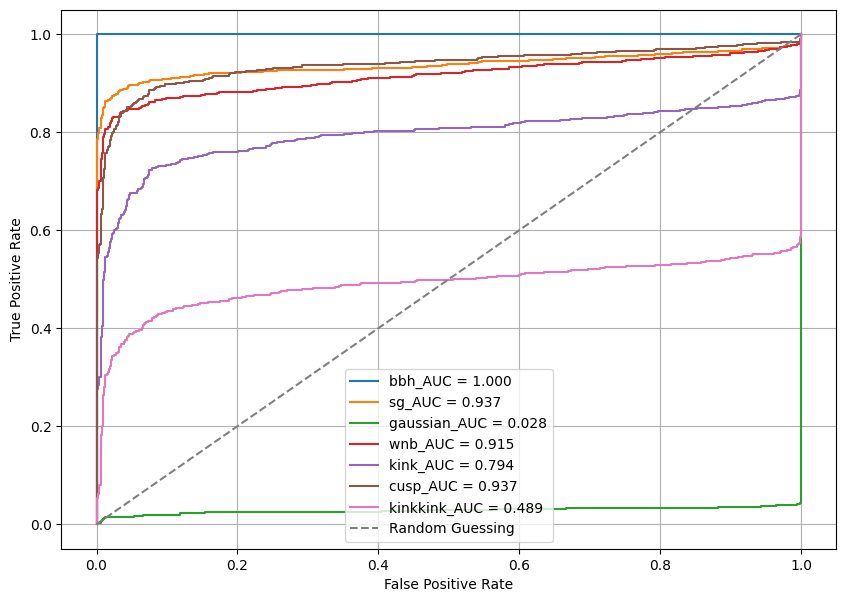

(np.float64(1.0),
 np.float64(0.9367868063842484),
 np.float64(0.028282752403846156),
 np.float64(0.9150101015717674),
 np.float64(0.7937263678825622),
 np.float64(0.9370236004490151),
 np.float64(0.48908797554347827))

In [128]:
def getfpr_tpr(model, bg_mse, anomaly):
    anomaly_pred = model.predict(anomaly)
    anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg_mse.shape[0]),np.ones(anomaly_mse.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, thresholds, auc_score

def eval(model, bg, bbh, sg, gaussian, wnb, kink, cusp, kinkkink):
    bg_pred = model.predict(bg)
    bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))

    bbh_fpr, bbh_tpr, bbh_thresholds, bbh_auc = getfpr_tpr(model, bg_mse, bbh)
    sg_fpr, sg_tpr, sg_thresholds, sg_auc = getfpr_tpr(model, bg_mse, sg)
    gaussian_fpr, gaussian_tpr, gaussian_thresholds, gaussian_auc = getfpr_tpr(model, bg_mse, gaussian)
    wnb_fpr, wnb_tpr, wnb_thresholds, wnb_auc = getfpr_tpr(model, bg_mse, wnb)
    kink_fpr, kink_tpr, kink_thresholds, kink_auc = getfpr_tpr(model, bg_mse, kink)
    cusp_fpr, cusp_tpr, cusp_thresholds, cusp_auc = getfpr_tpr(model, bg_mse, cusp)
    kinkkink_fpr, kinkkink_tpr, kinkkink_thresholds, kinkkink_auc = getfpr_tpr(model, bg_mse, kinkkink)

    plt.figure(figsize=(10, 7))
    plt.plot(bbh_fpr, bbh_tpr,label=f'bbh_AUC = {bbh_auc:.3f}')
    plt.plot(sg_fpr, sg_tpr,label=f'sg_AUC = {sg_auc:.3f}')
    plt.plot(gaussian_fpr, gaussian_tpr,label=f'gaussian_AUC = {gaussian_auc:.3f}')
    plt.plot(wnb_fpr, wnb_tpr,label=f'wnb_AUC = {wnb_auc:.3f}')
    plt.plot(kink_fpr, kink_tpr,label=f'kink_AUC = {kink_auc:.3f}')
    plt.plot(cusp_fpr, cusp_tpr,label=f'cusp_AUC = {cusp_auc:.3f}')
    plt.plot(kinkkink_fpr, kinkkink_tpr,label=f'kinkkink_AUC = {kinkkink_auc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.legend()
    plt.show()

    return bbh_auc, sg_auc, gaussian_auc, wnb_auc, kink_auc, cusp_auc, kinkkink_auc

eval(AE, background_test, BBH, SG, Gaussian, WNB, Kink, Cusp, KinkKink)


In [129]:
print(bbh_auc, sglf_auc, gaussian_auc, WNb_auc, kinks_auc, kinkkink_auc, cusps_auc)

1.0 0.9359664006563244 0.029346955128205125 0.9160689131079479 0.7977137084816133 0.9389303302433372 0.4930614526721015


In [130]:
np.mean(BBH[:,:,-1]),np.mean(SG[:,:,-1]),np.mean(Gaussian[:,:,-1]),np.mean(WNB[:,:,-1]),np.mean(Kink[:,:,-1]),np.mean(KinkKink[:,:,-1]),np.mean(Cusp[:,:,-1])

(np.float32(53.174095),
 np.float32(1.6664346),
 np.float32(1.0613845e-05),
 np.float32(-0.828807),
 np.float32(0.066381365),
 np.float32(0.001596973),
 np.float32(0.066945136))

In [131]:
np.mean(background_train[:,:,-1])

np.float32(0.0005247973)


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-01.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


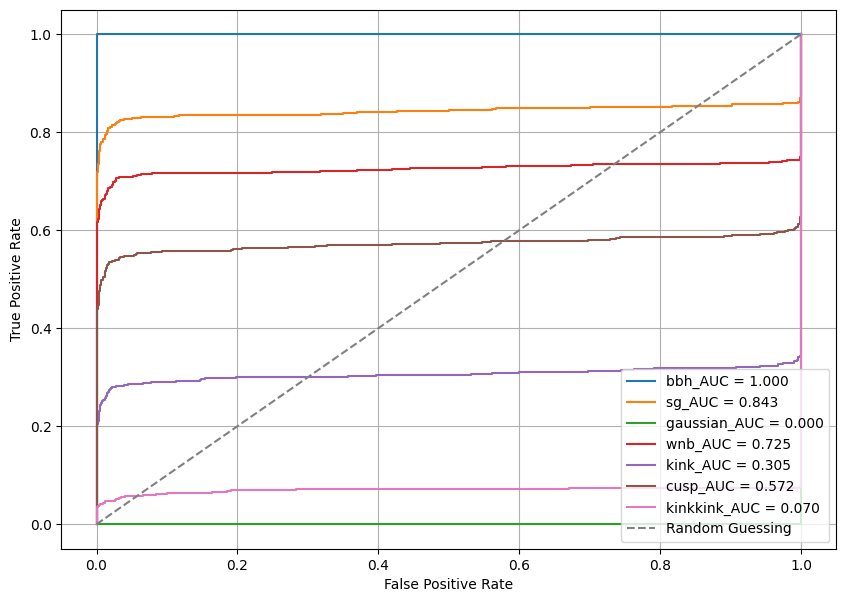


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-02.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


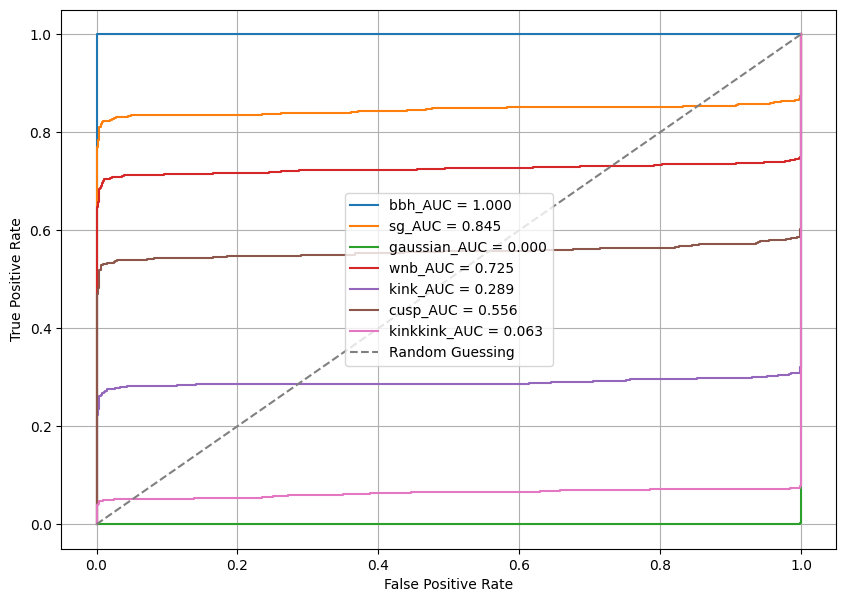


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-03.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


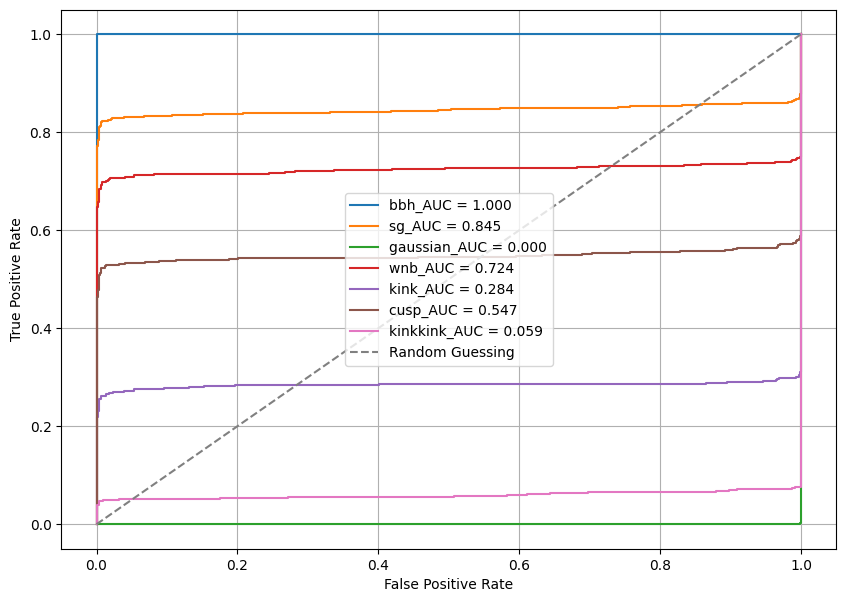


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-04.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


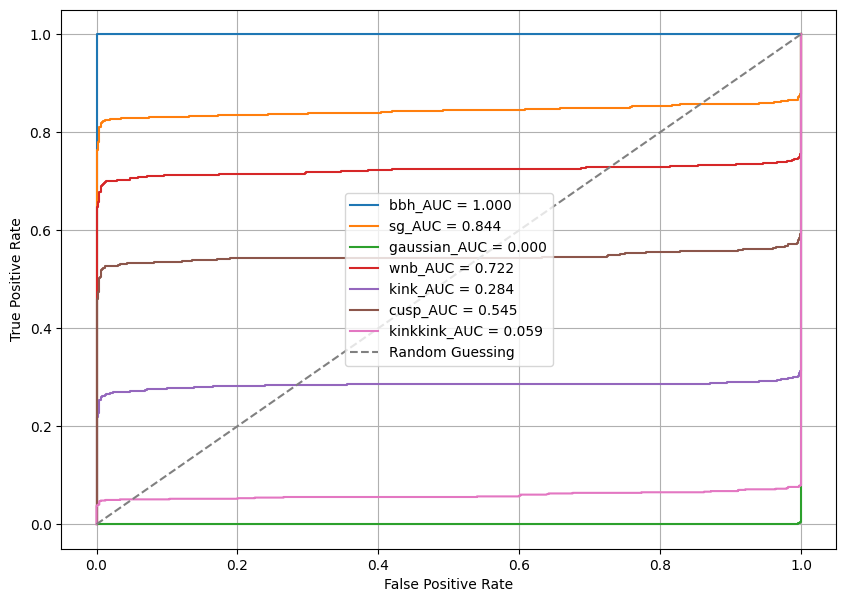


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-05.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


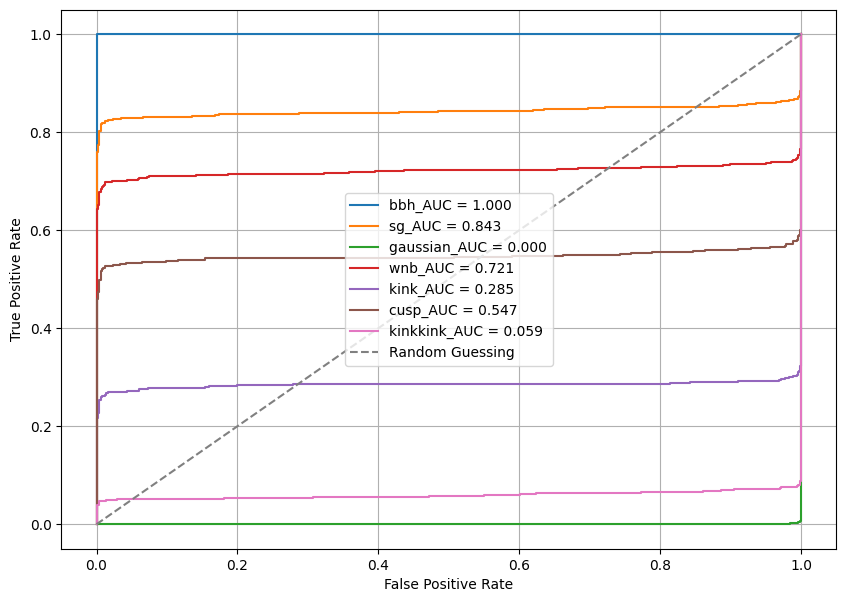


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-06.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


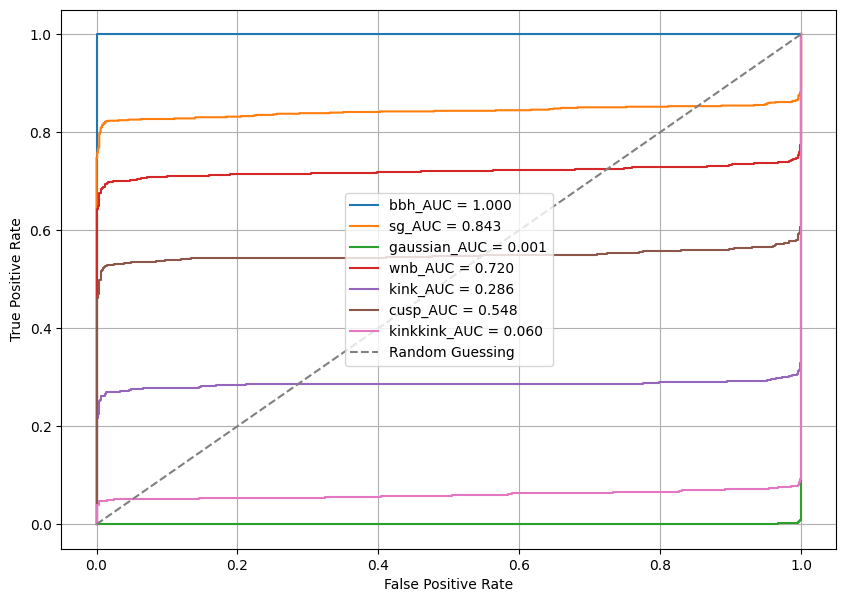


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-07.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


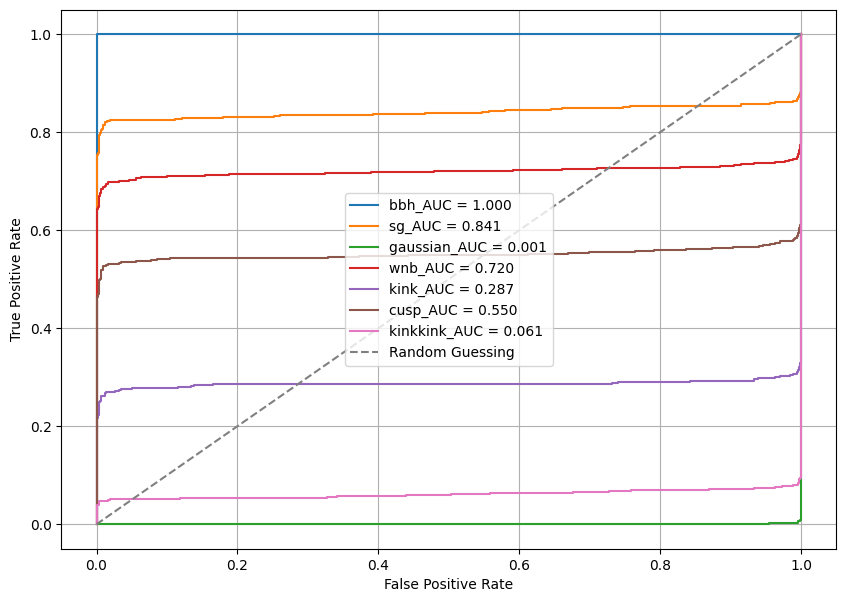


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-08.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


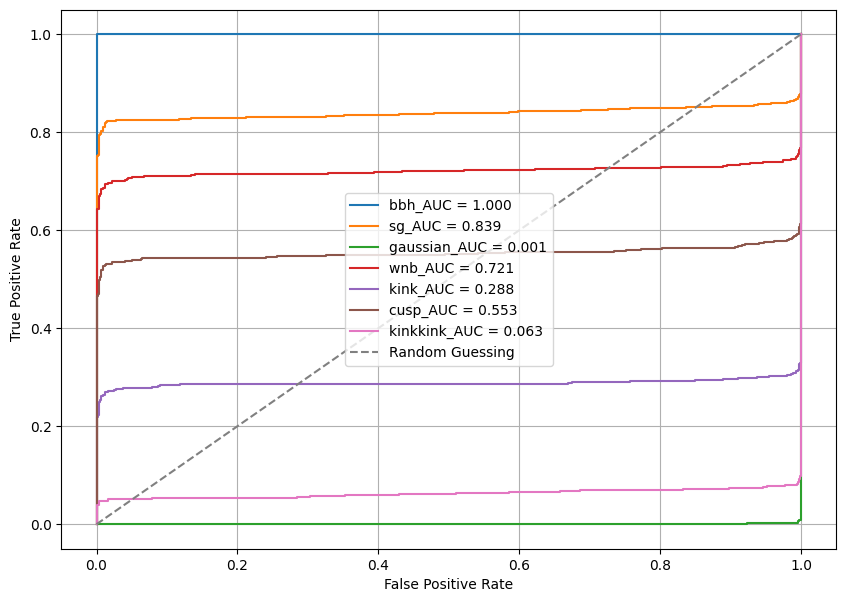


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-09.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


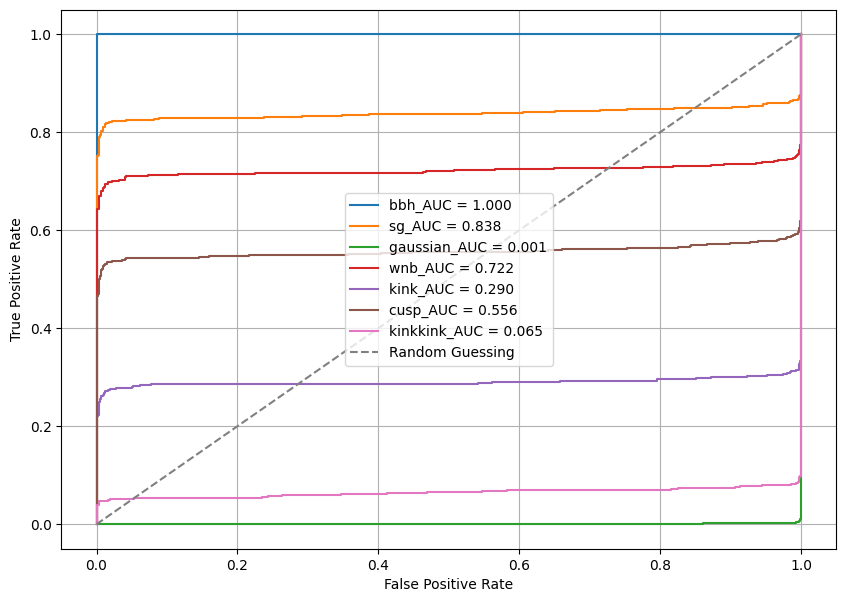


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-10.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


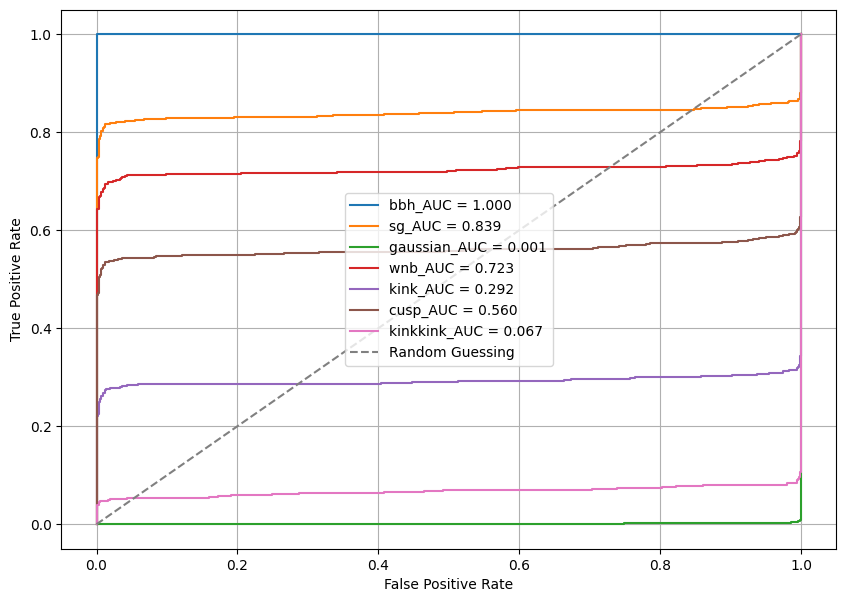


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-100.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


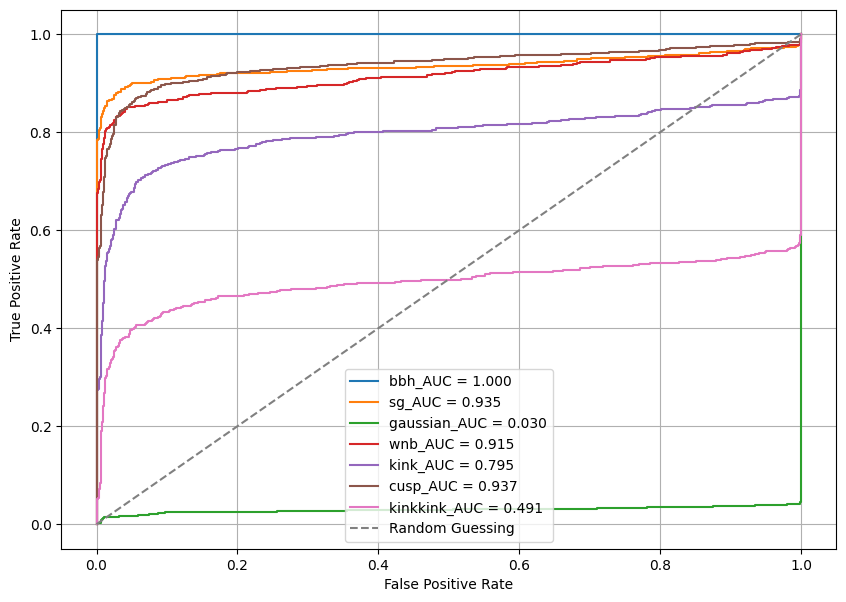


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-101.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


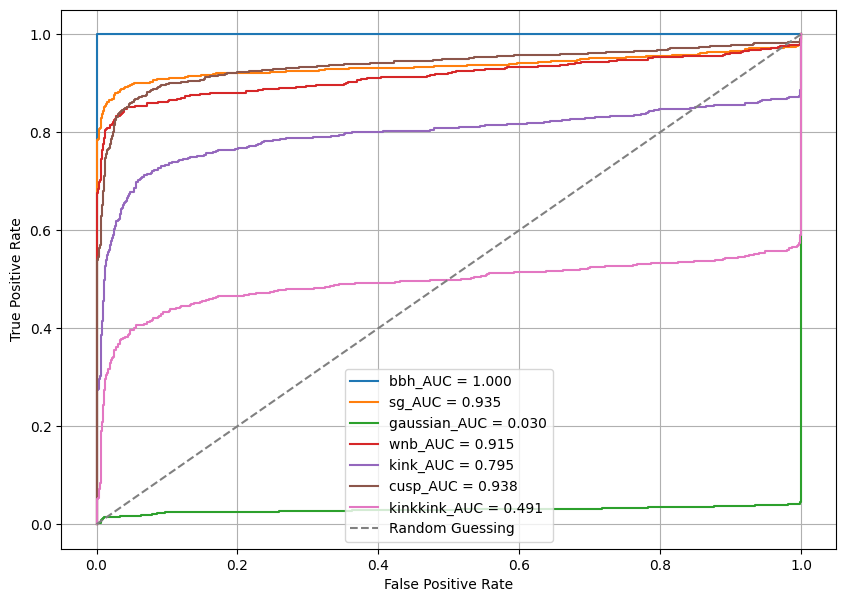


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-102.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


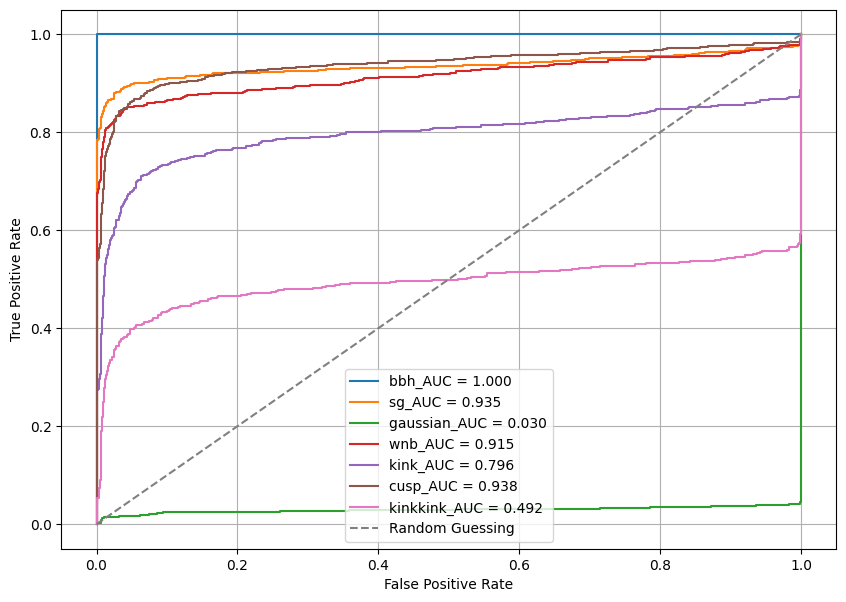


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-103.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


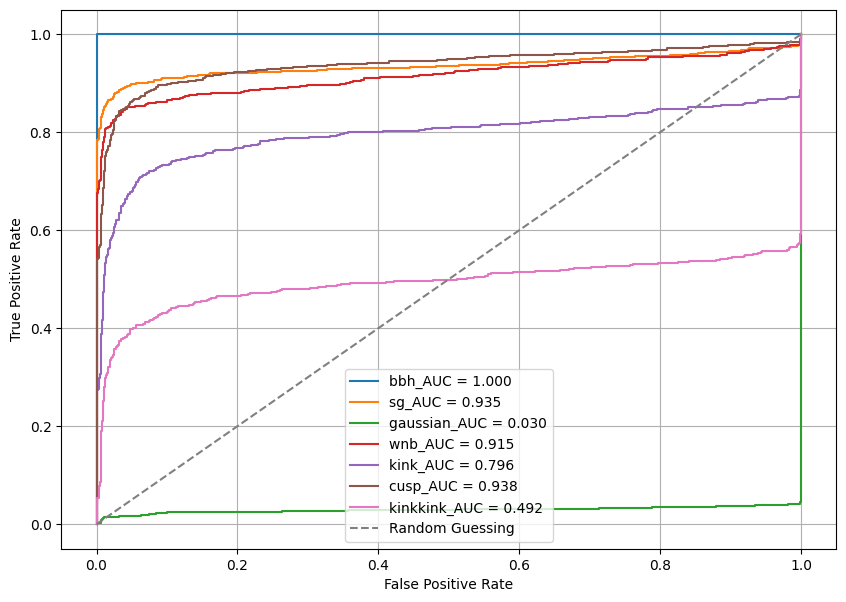


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-104.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


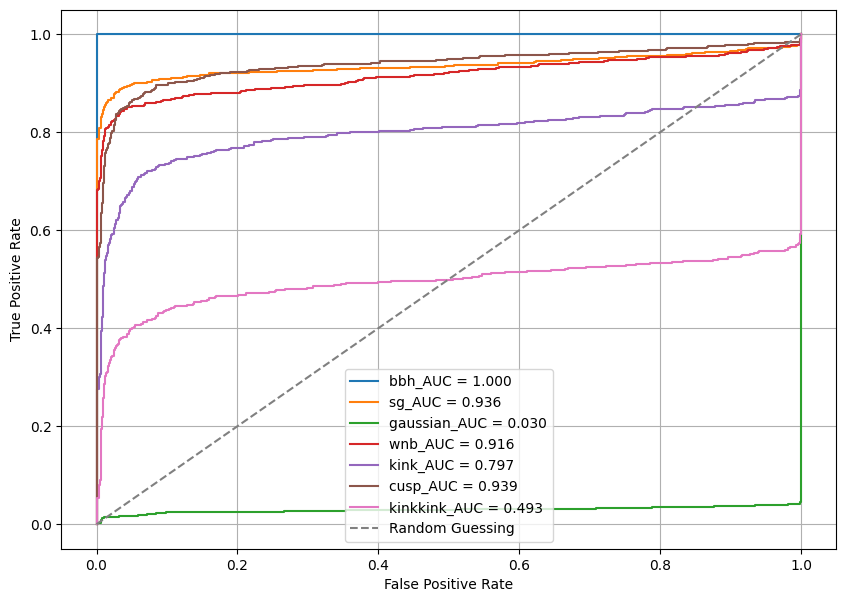


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-105.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


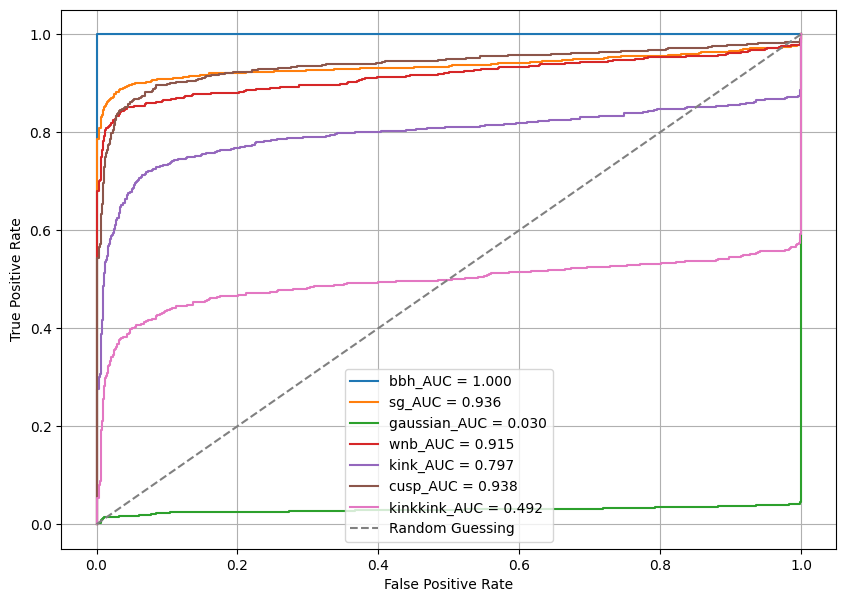


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-106.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


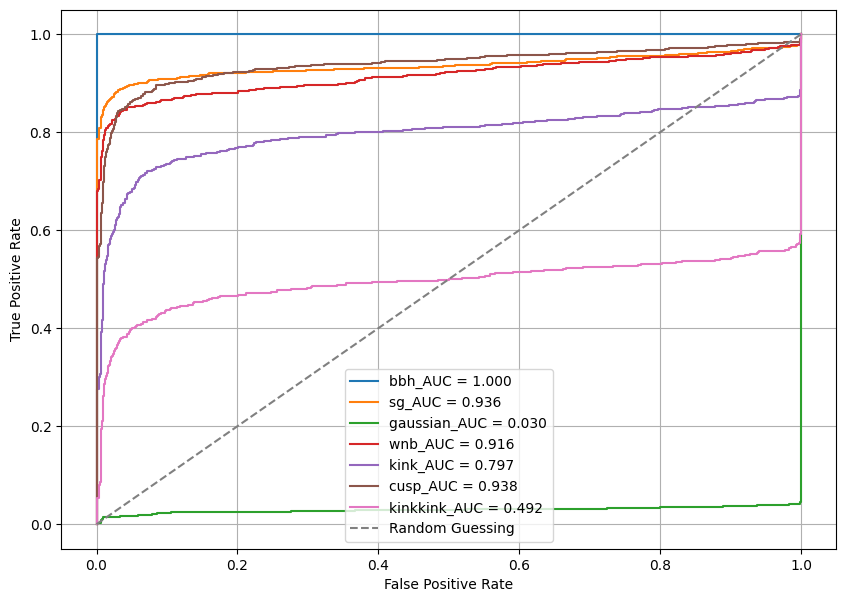


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-107.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


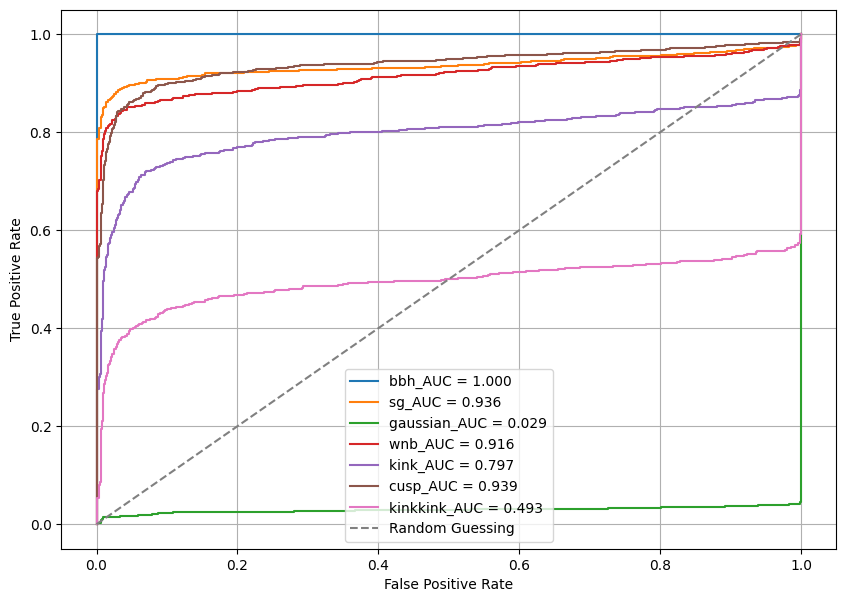


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-108.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


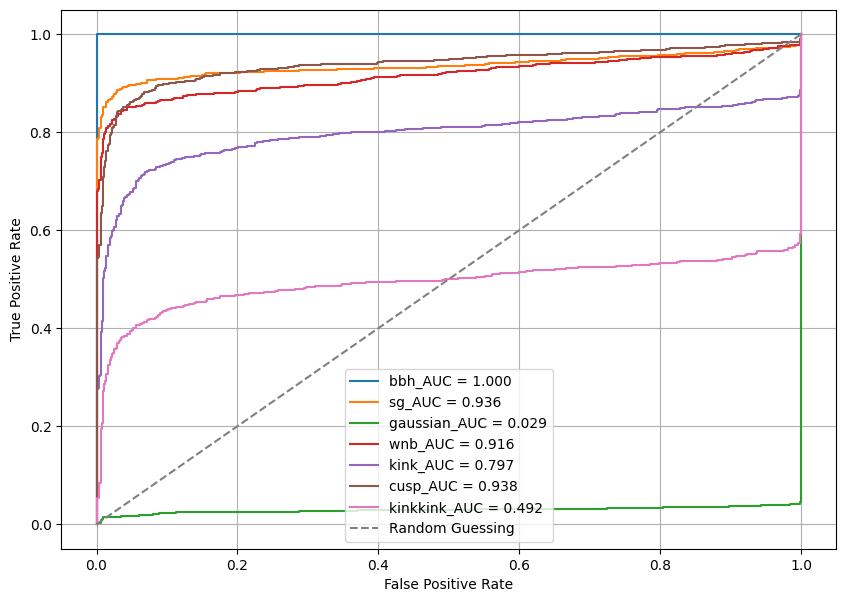


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-109.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


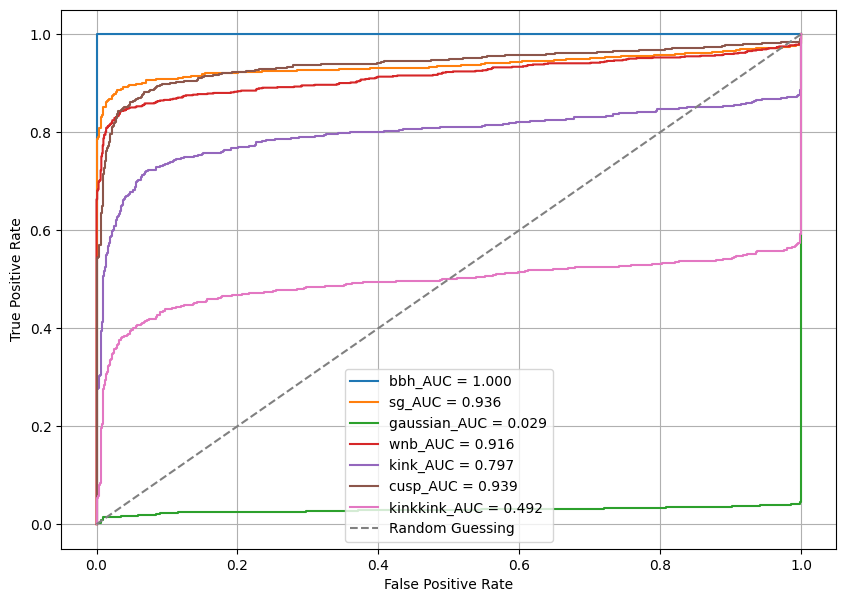


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-11.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


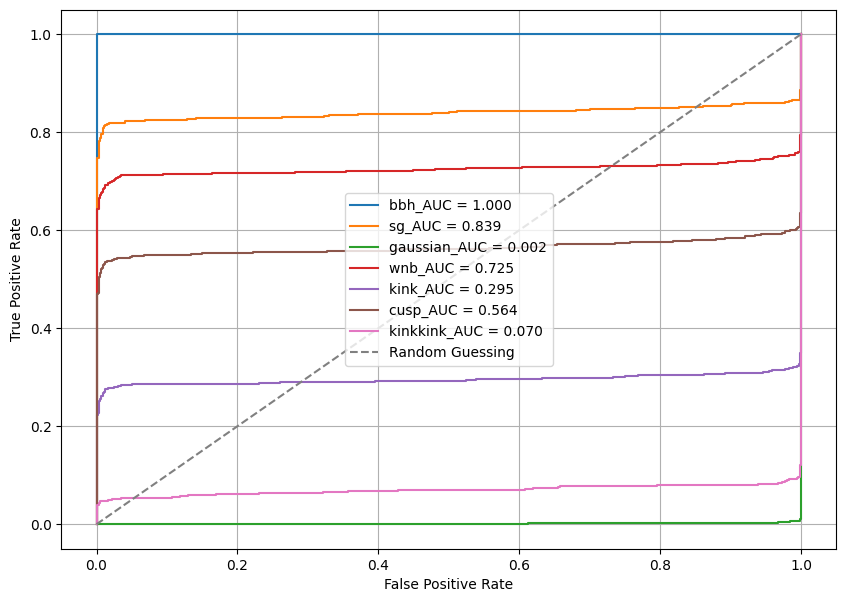


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-110.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


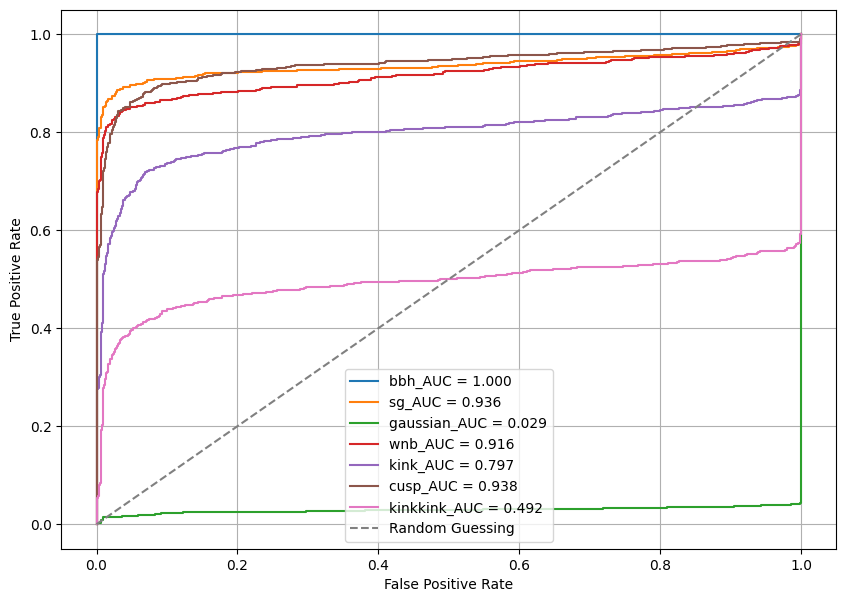


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-111.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


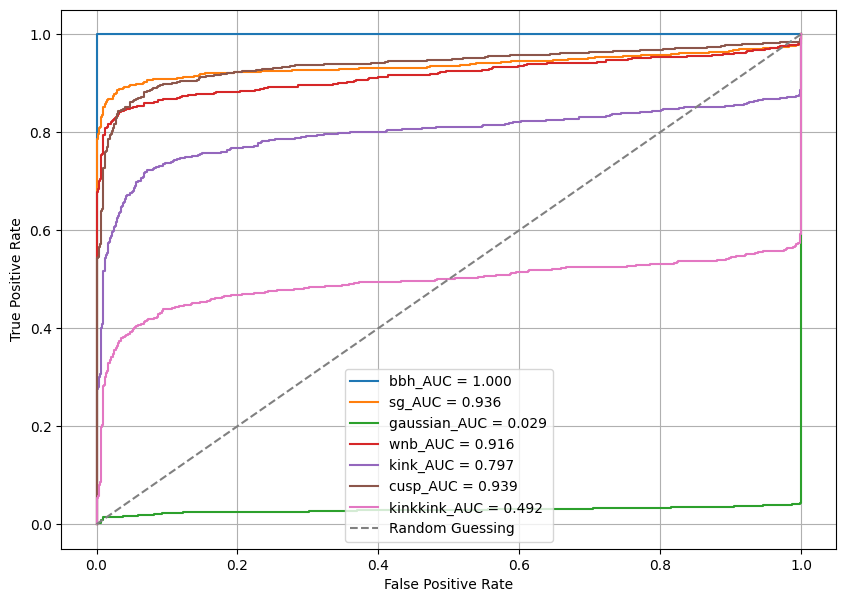


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-112.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


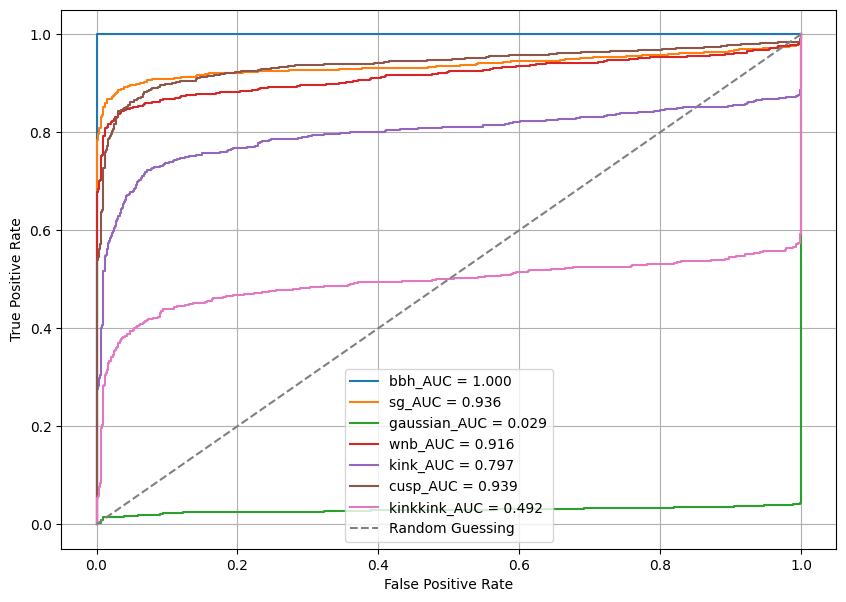


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-113.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


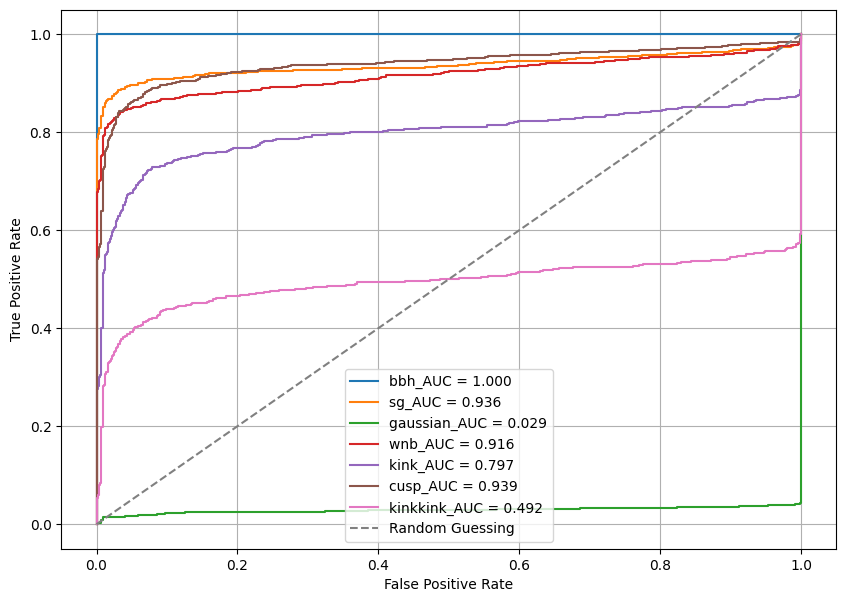


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-114.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


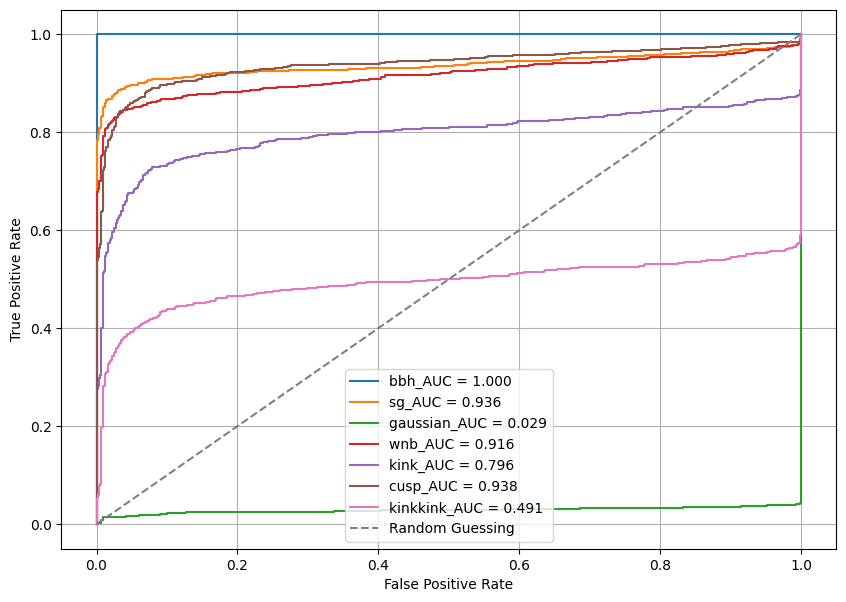


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-115.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


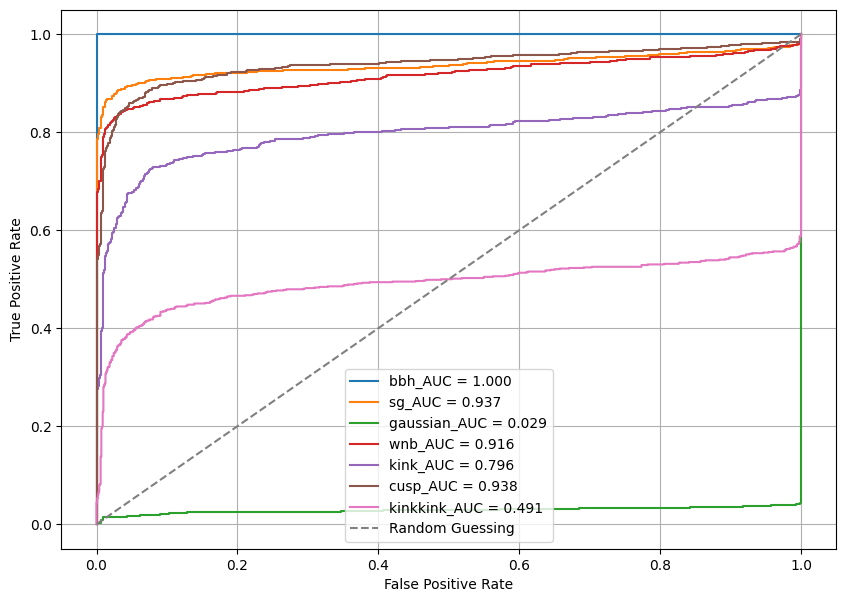


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-116.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


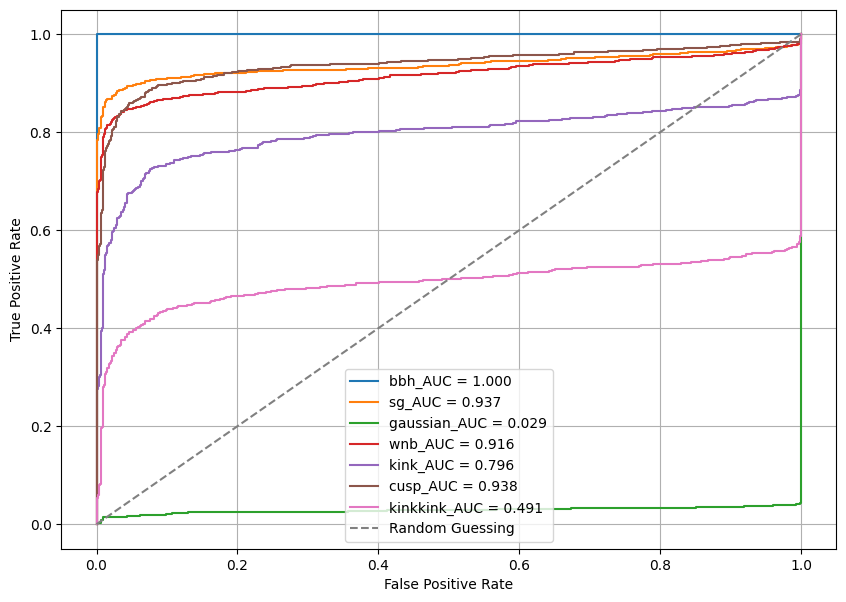


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-117.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


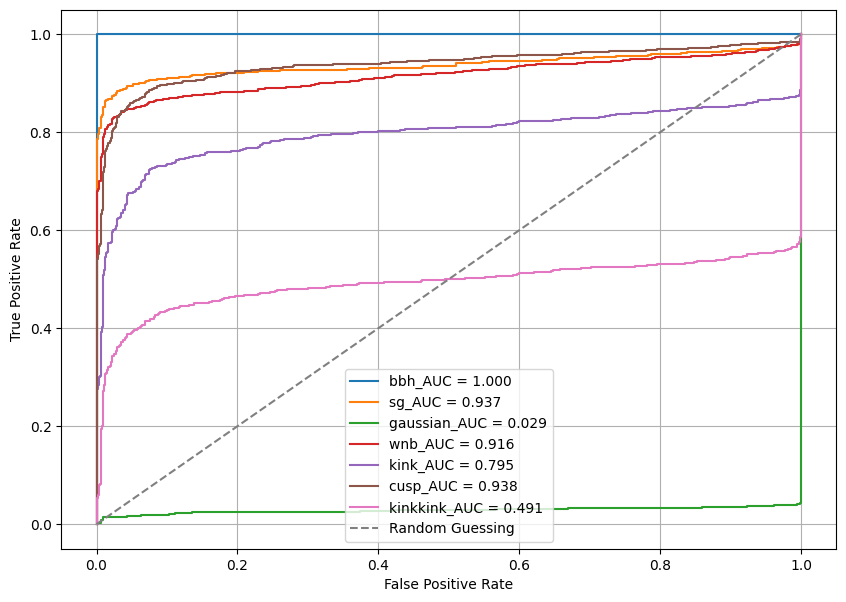


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-118.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


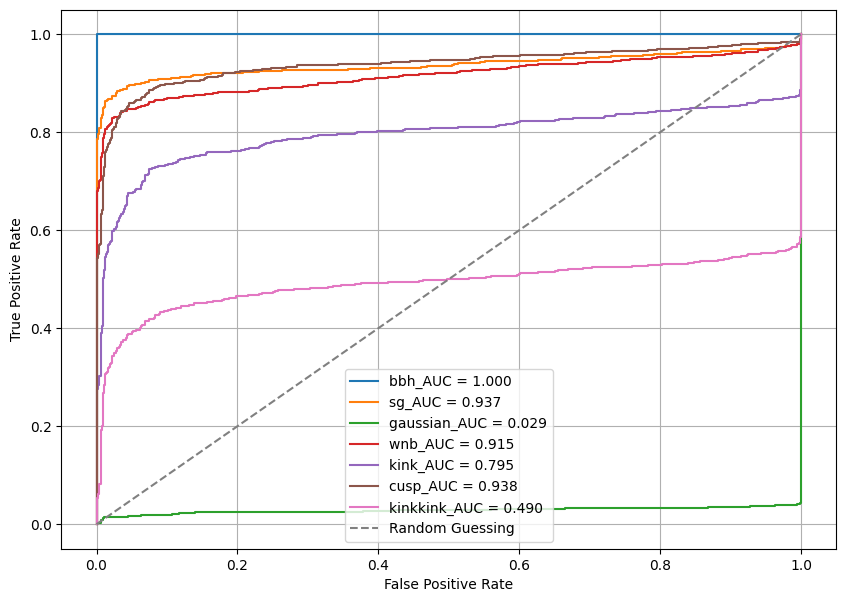


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-119.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


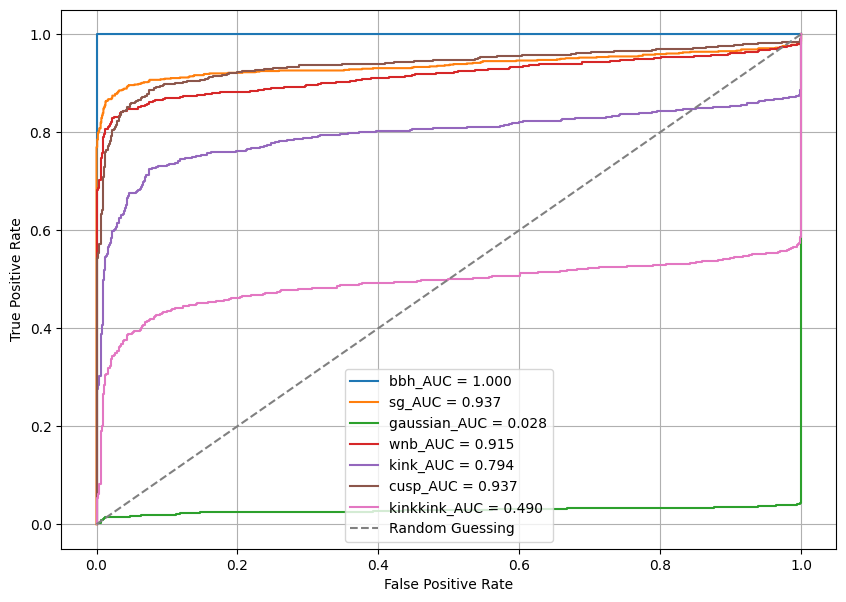


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-12.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


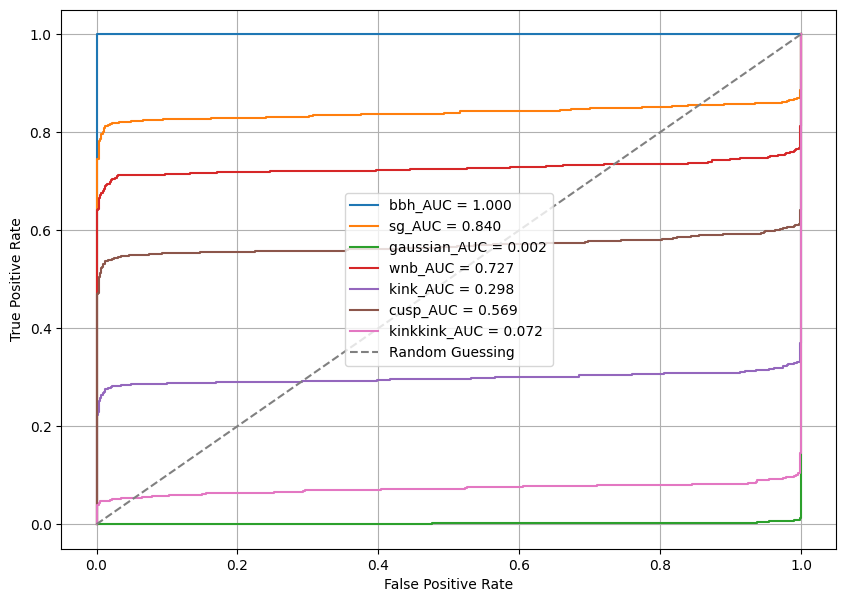


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-120.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


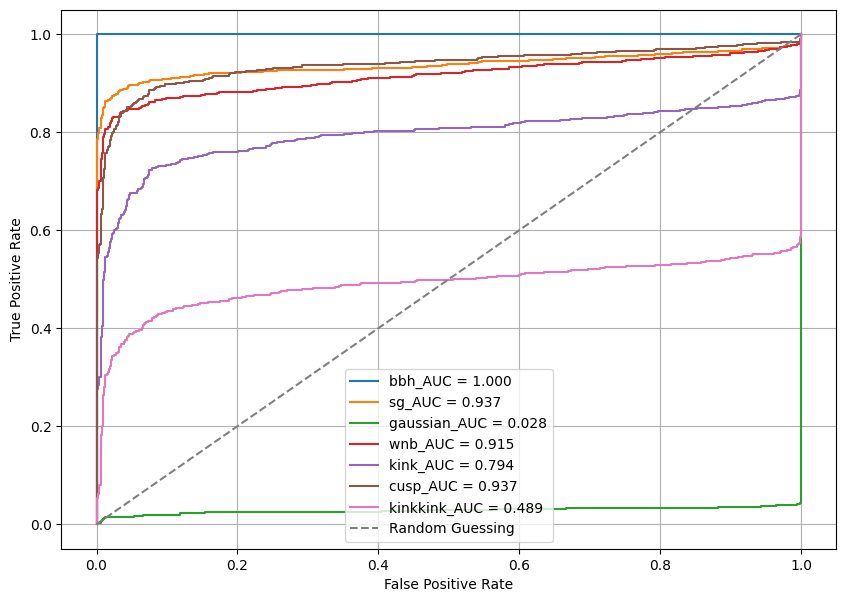


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-13.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


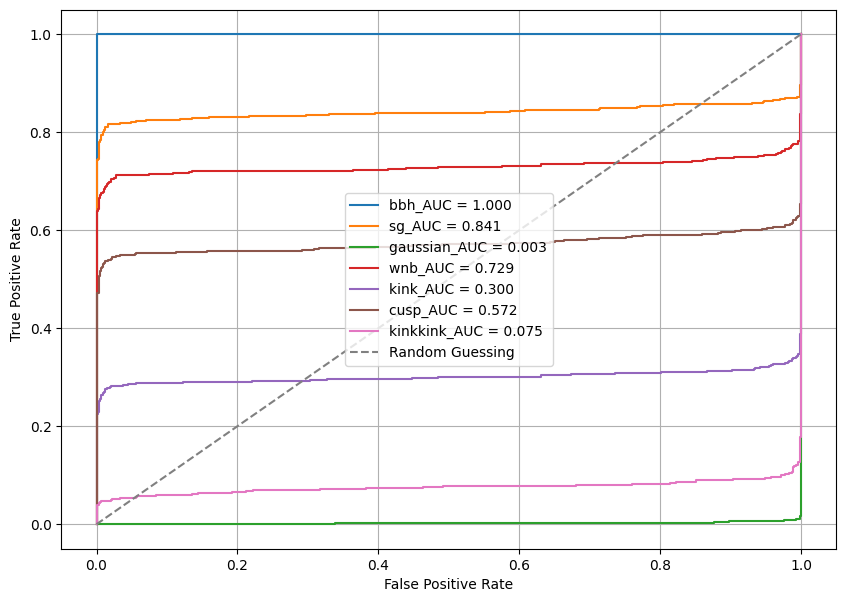


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-14.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


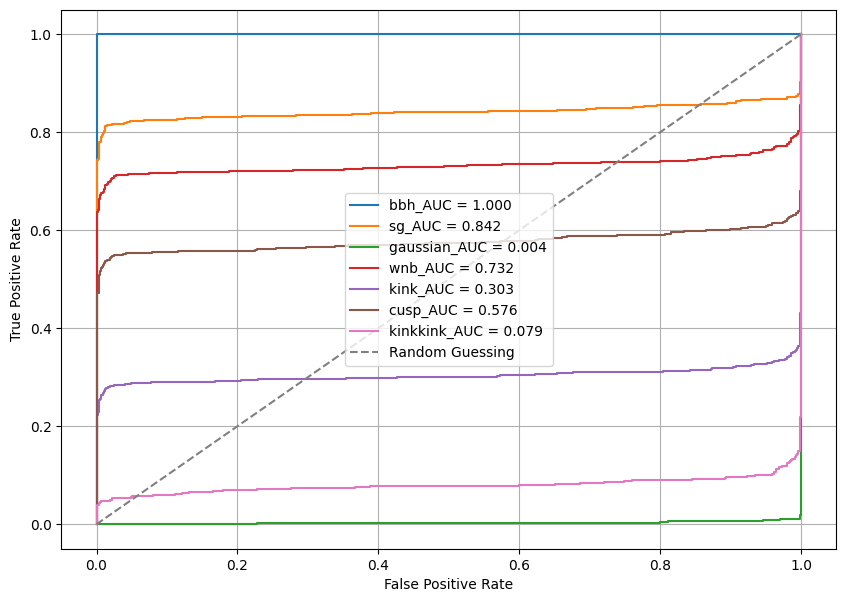


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-15.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


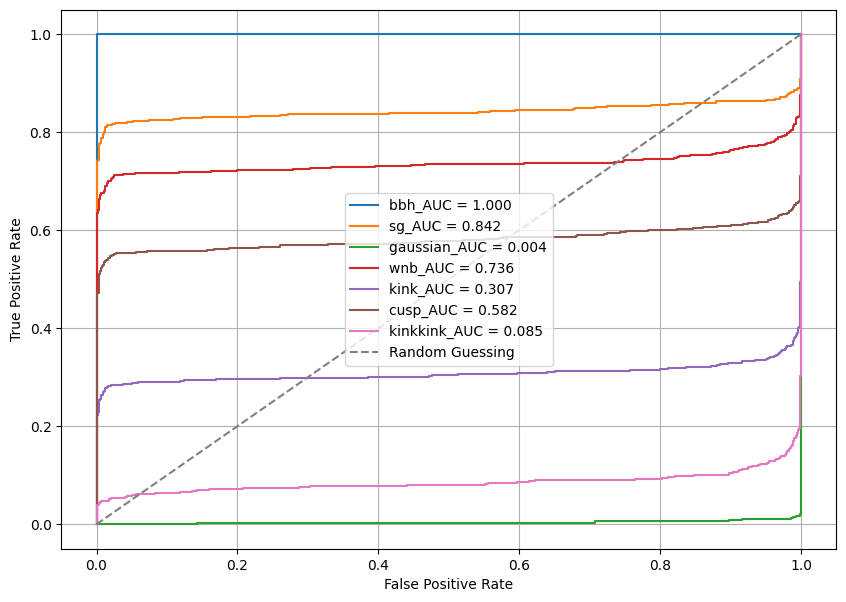


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-16.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


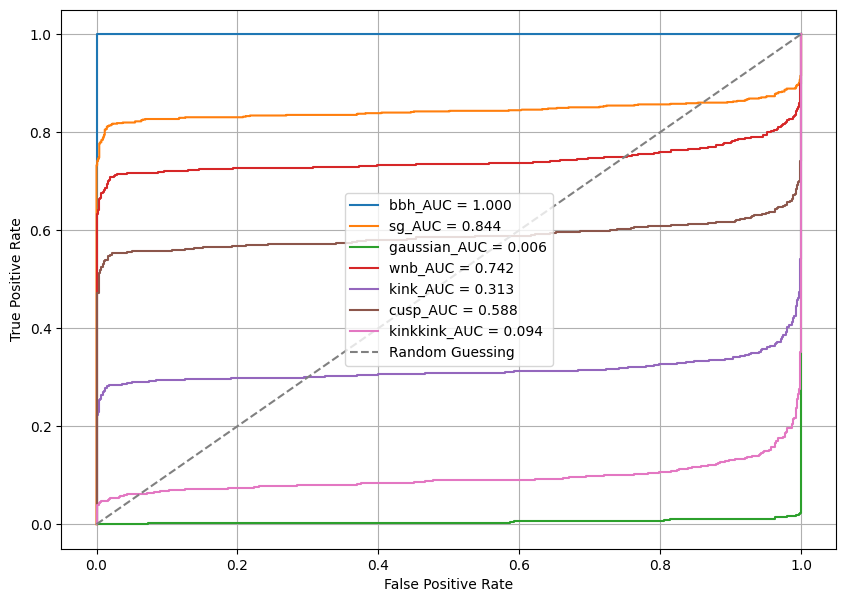


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-17.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


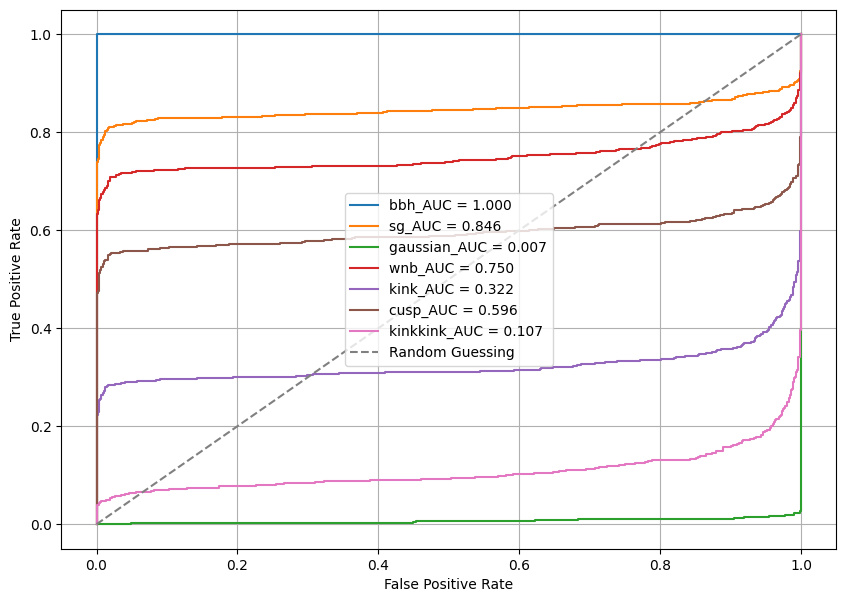


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-18.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


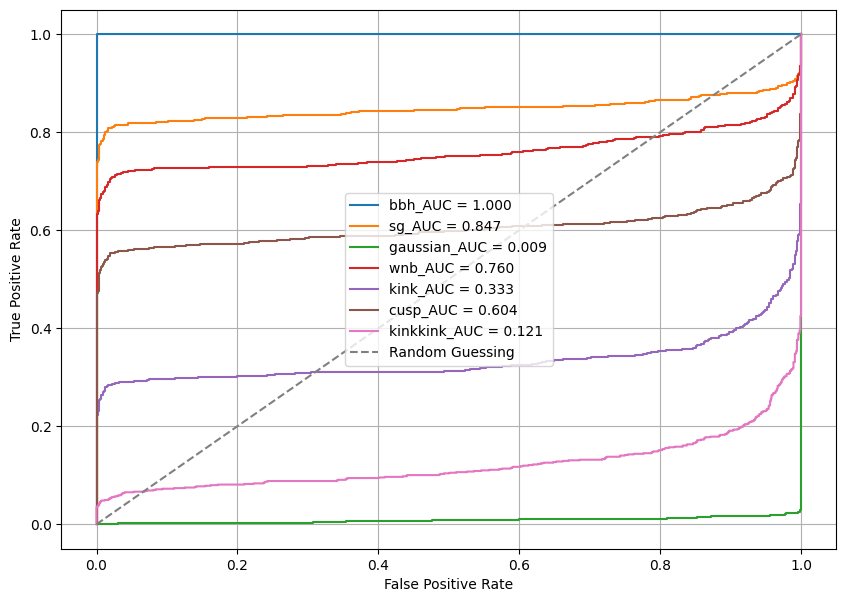


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-19.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


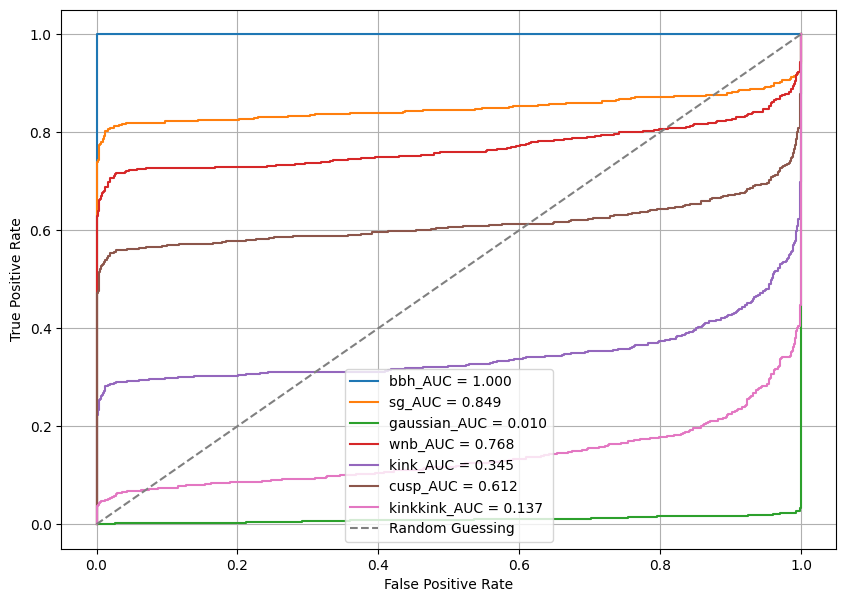


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-20.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


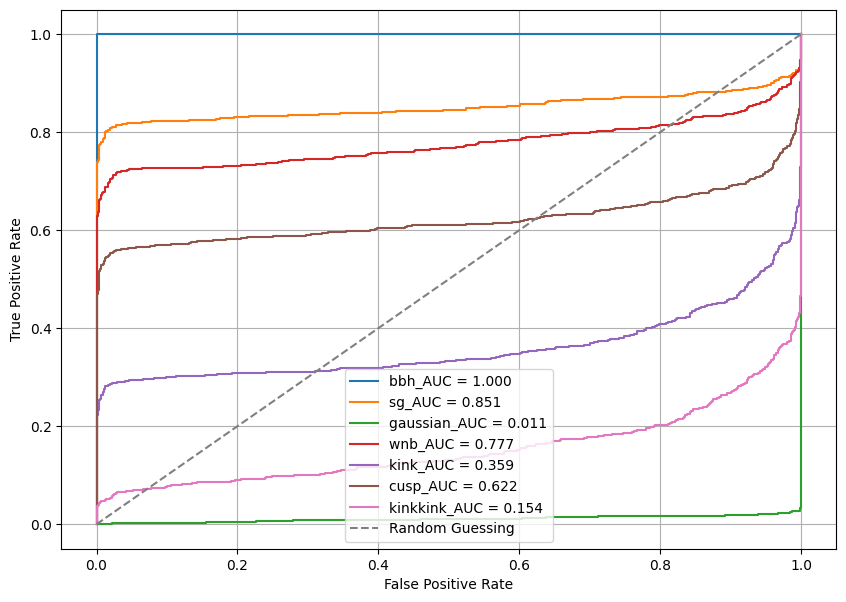


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-21.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


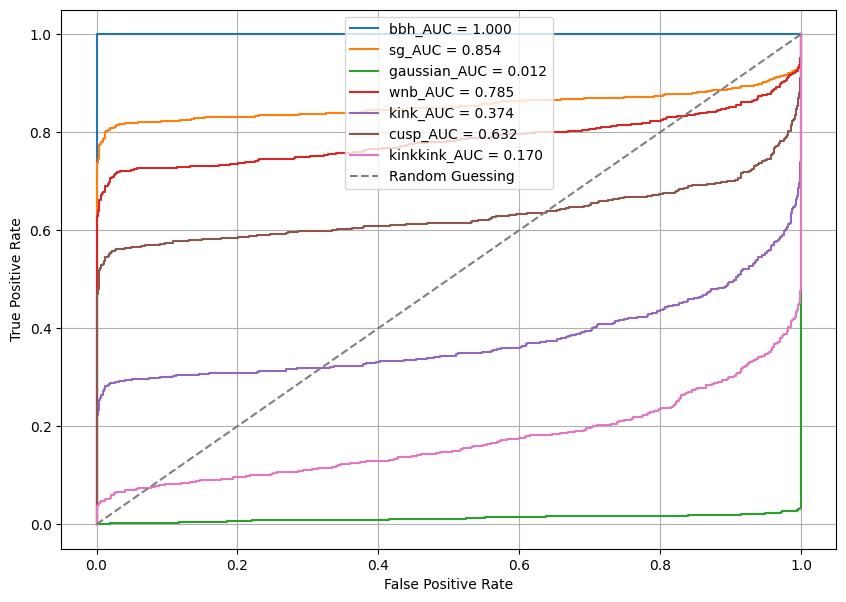


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-22.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


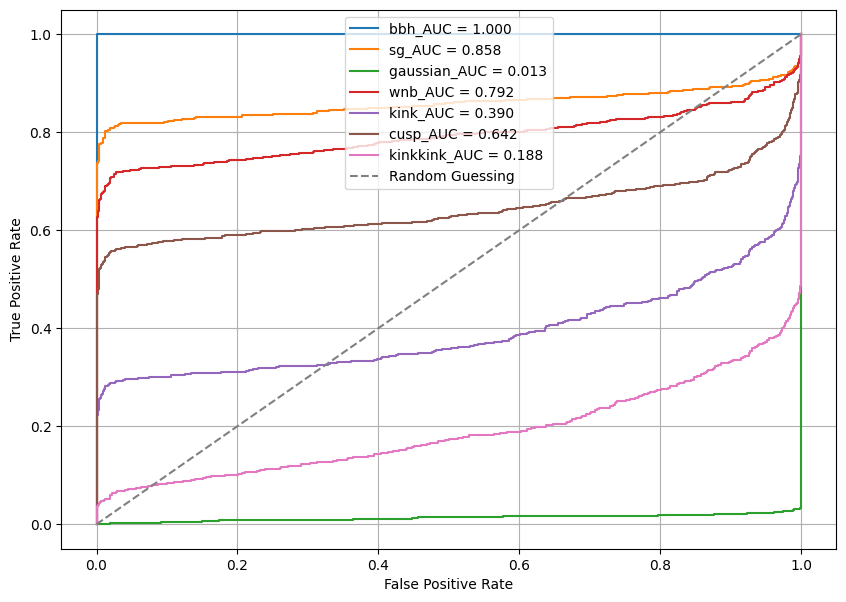


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-23.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


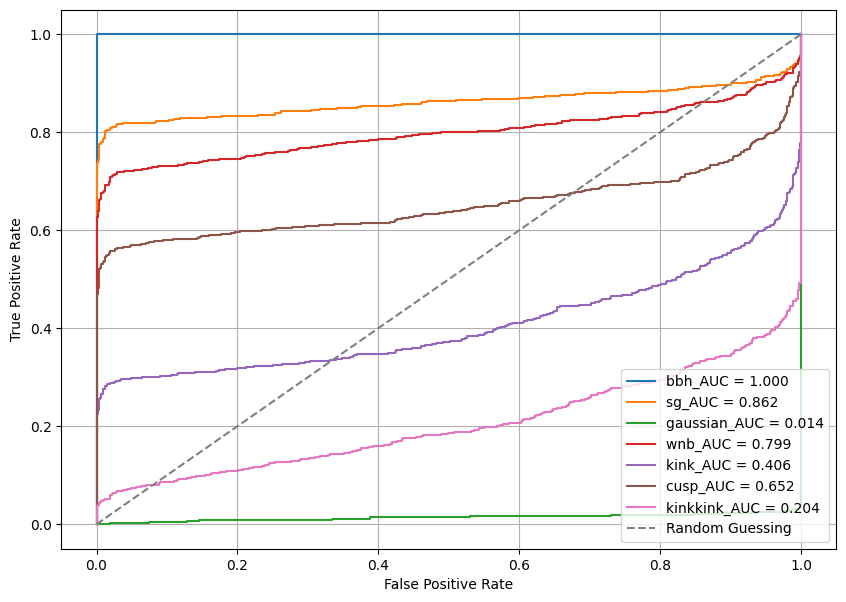


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-24.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


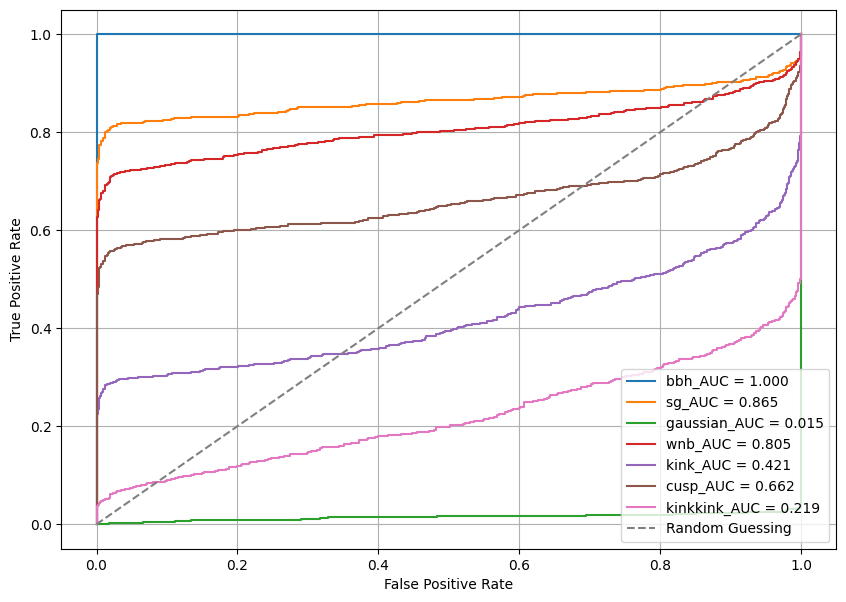


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-25.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


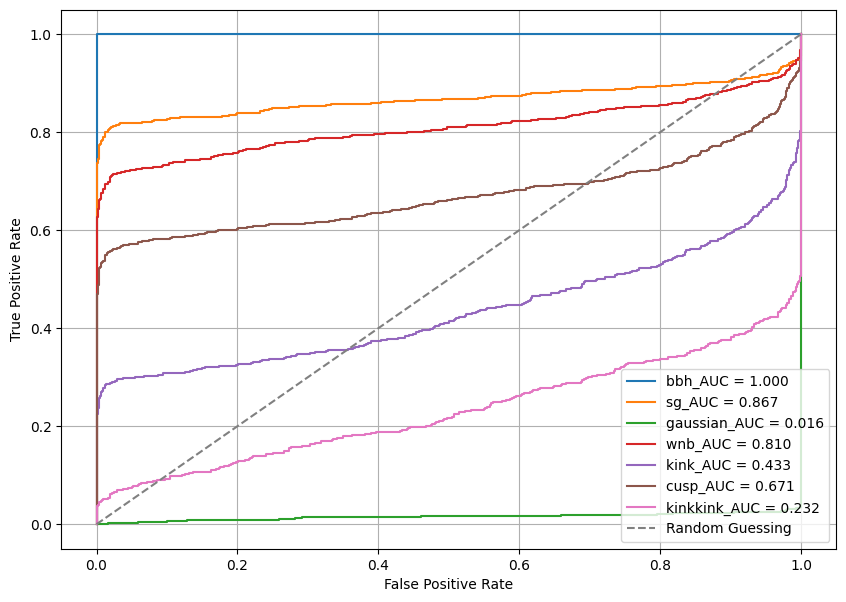


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-26.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


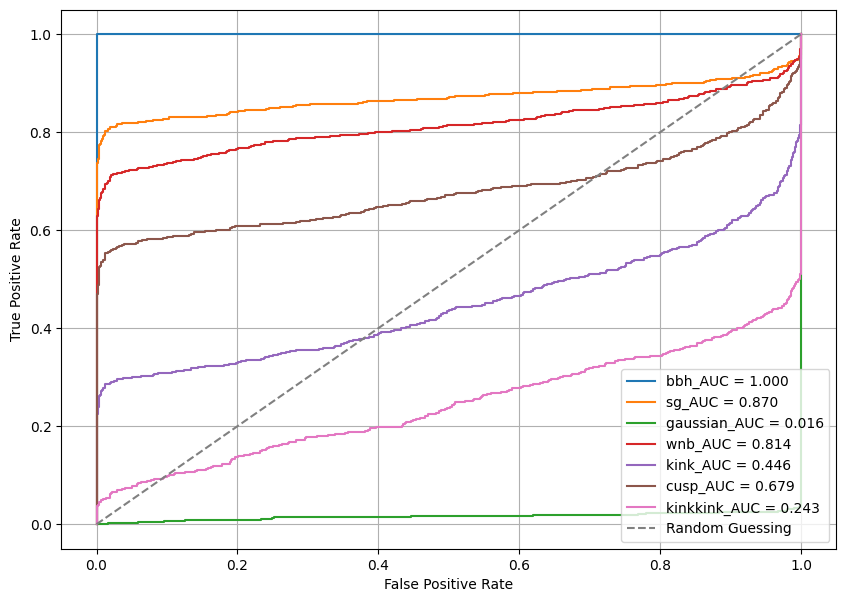


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-27.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


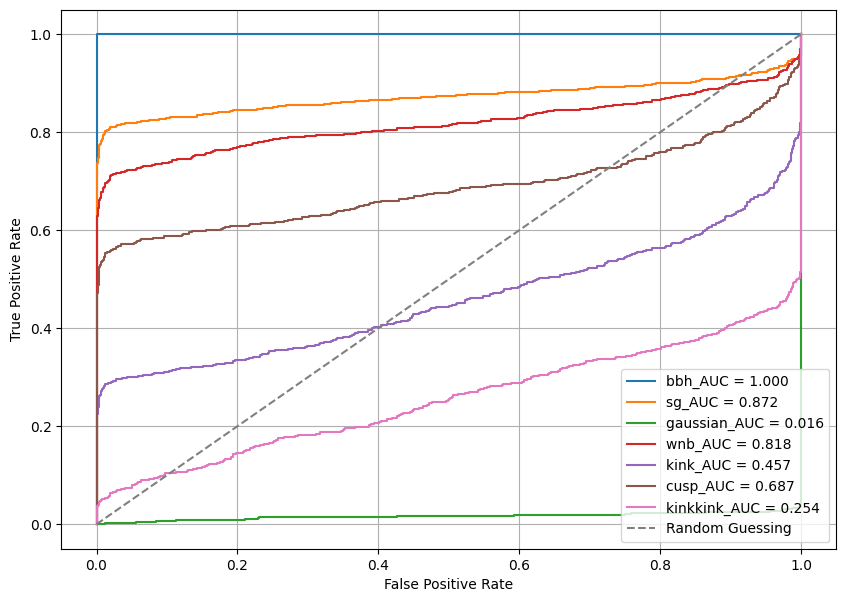


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-28.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


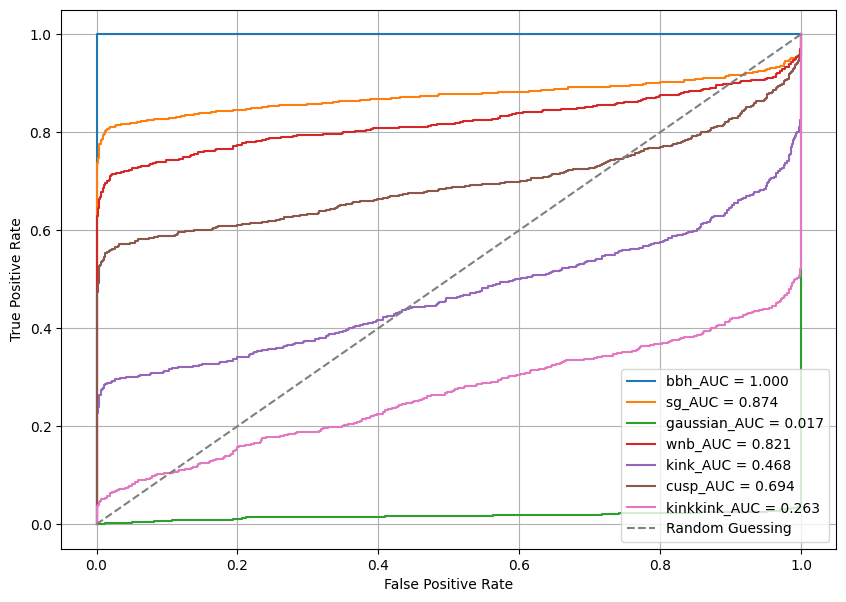


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-29.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


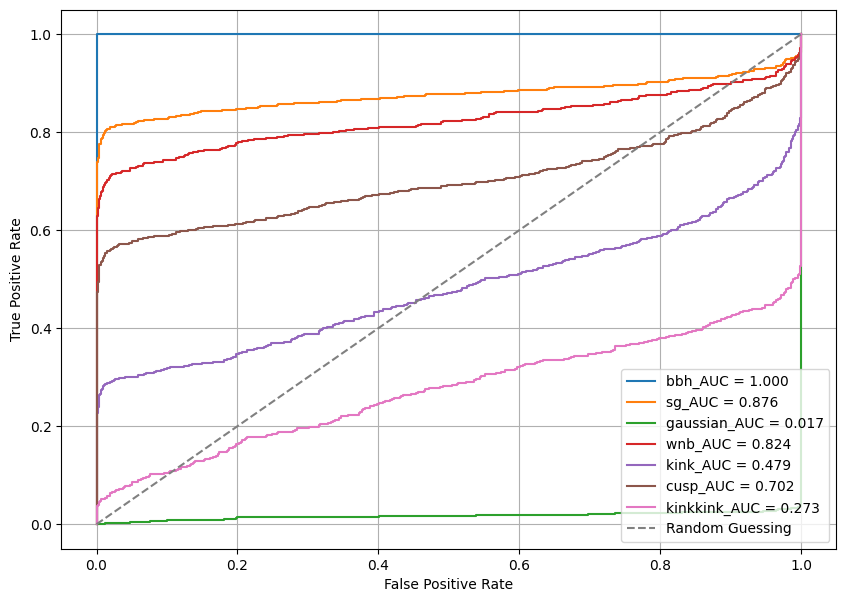


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-30.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


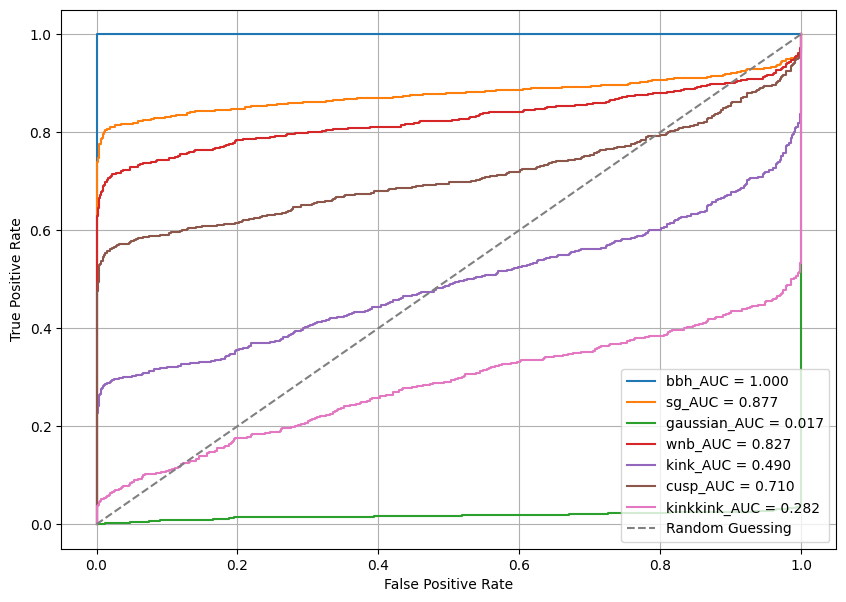


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-31.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


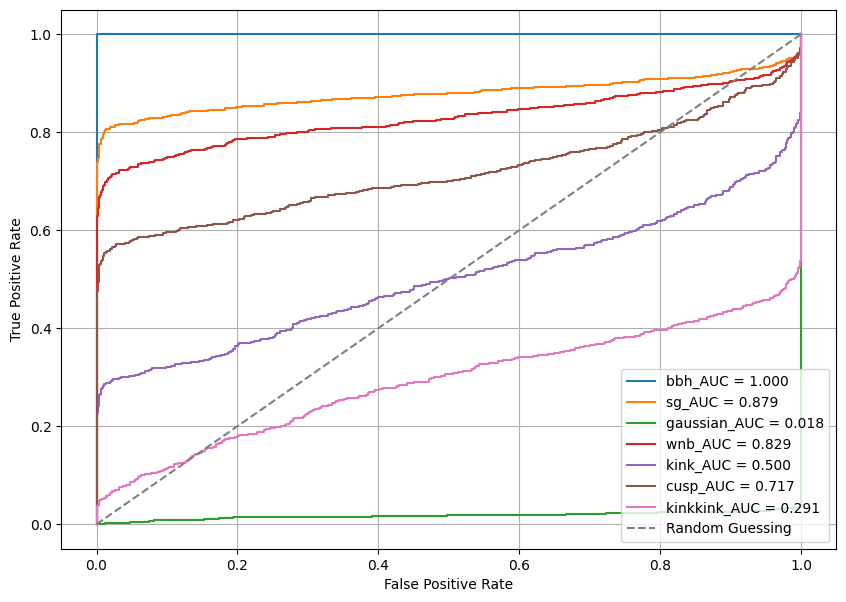


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-32.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


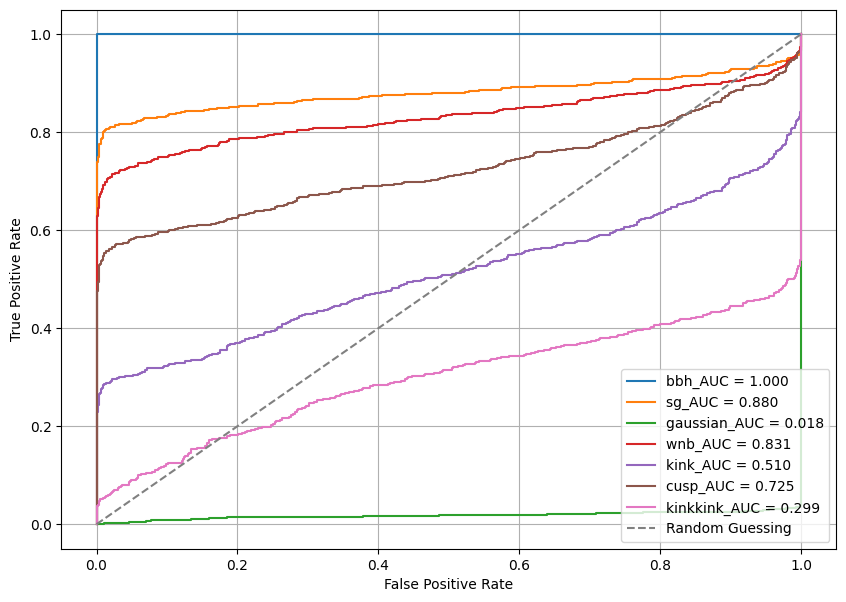


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-33.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


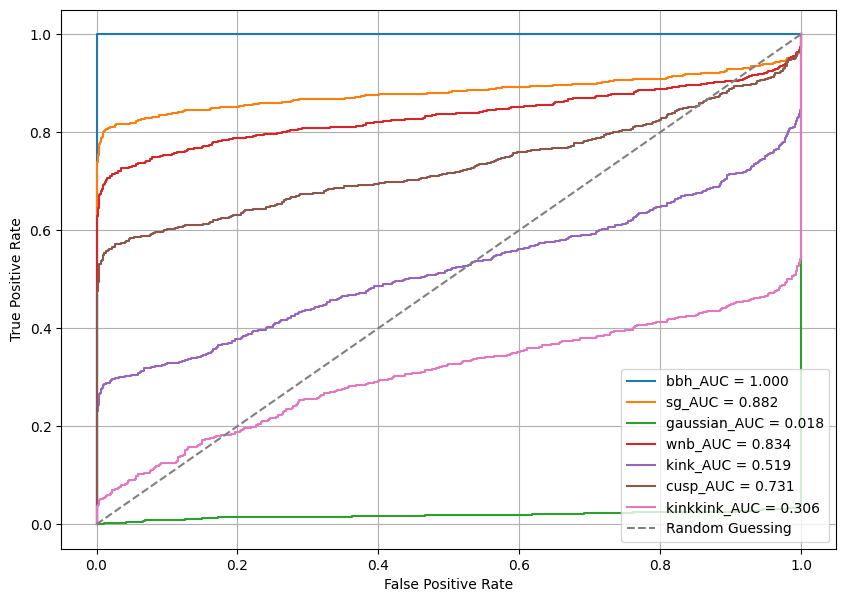


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-34.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


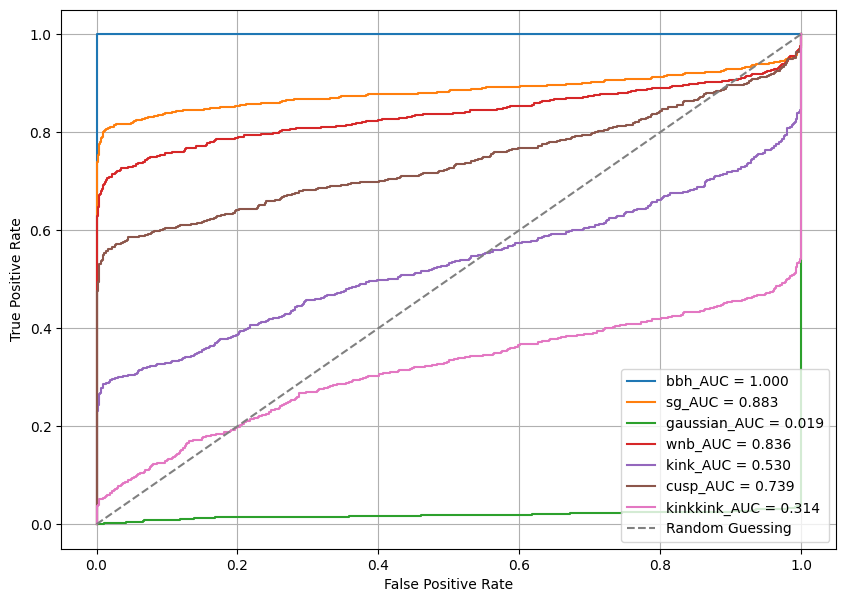


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-35.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


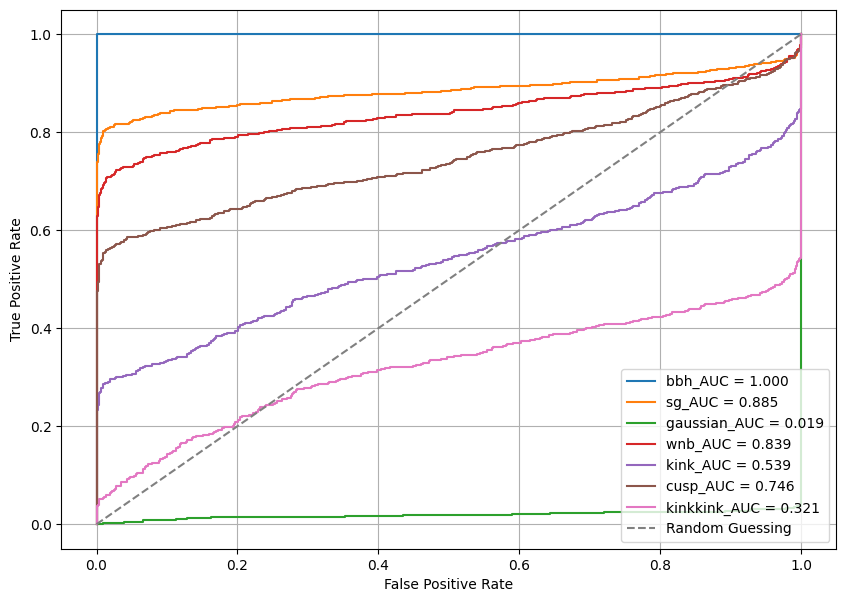


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-36.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


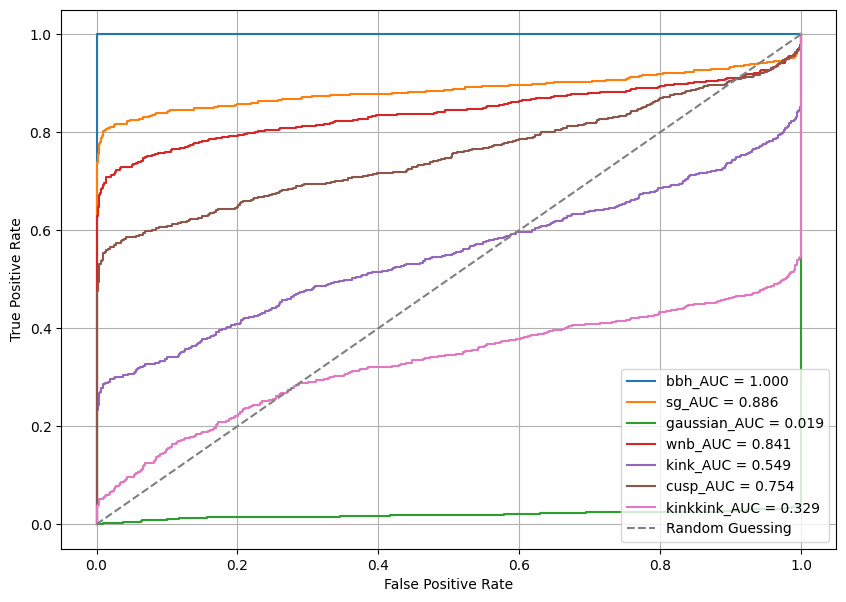


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-37.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


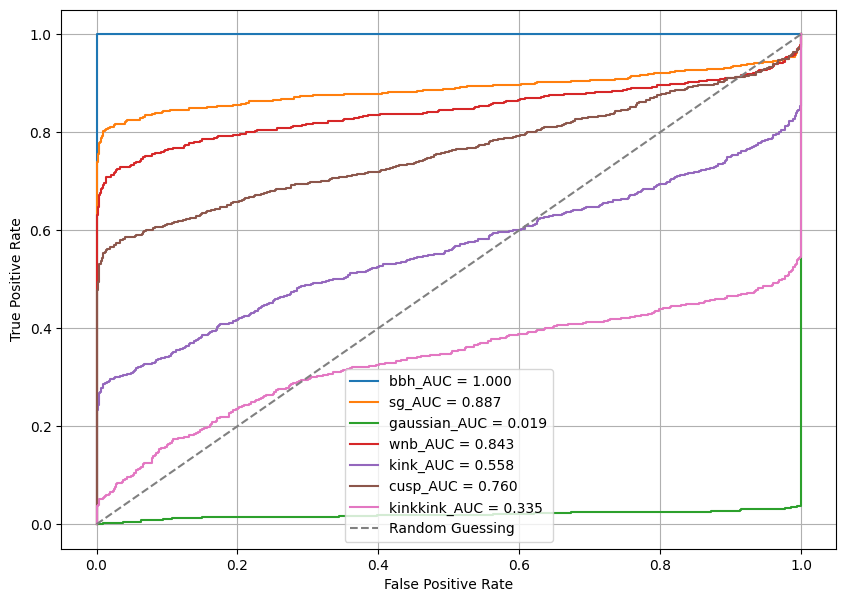


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-38.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


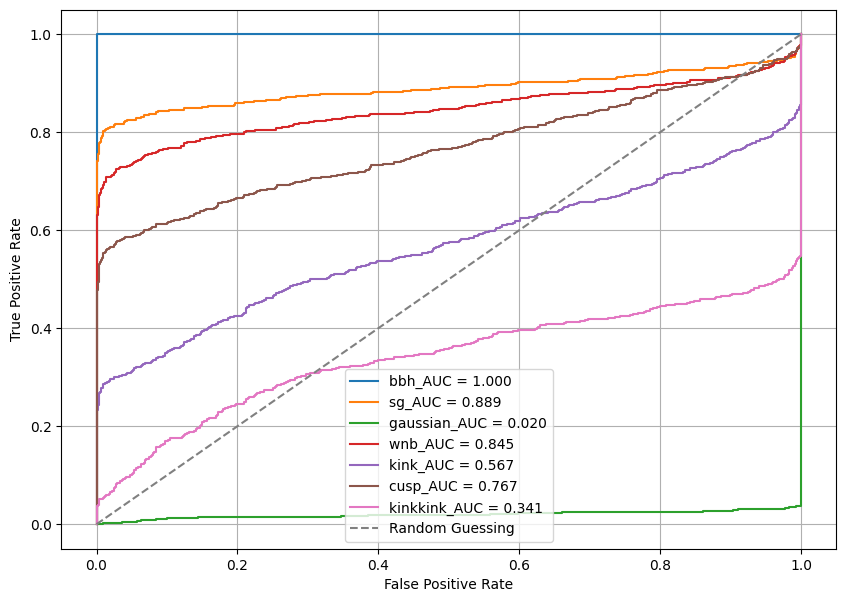


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-39.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


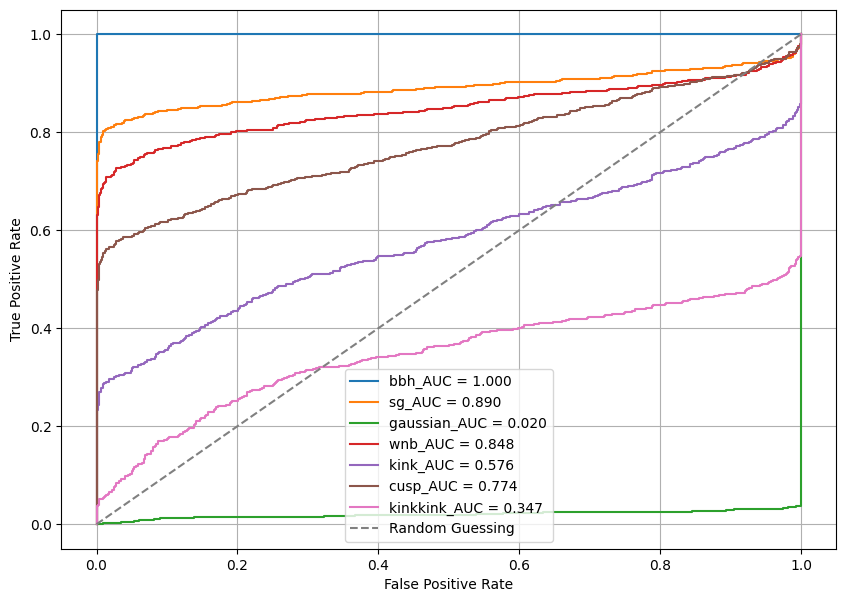


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-40.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


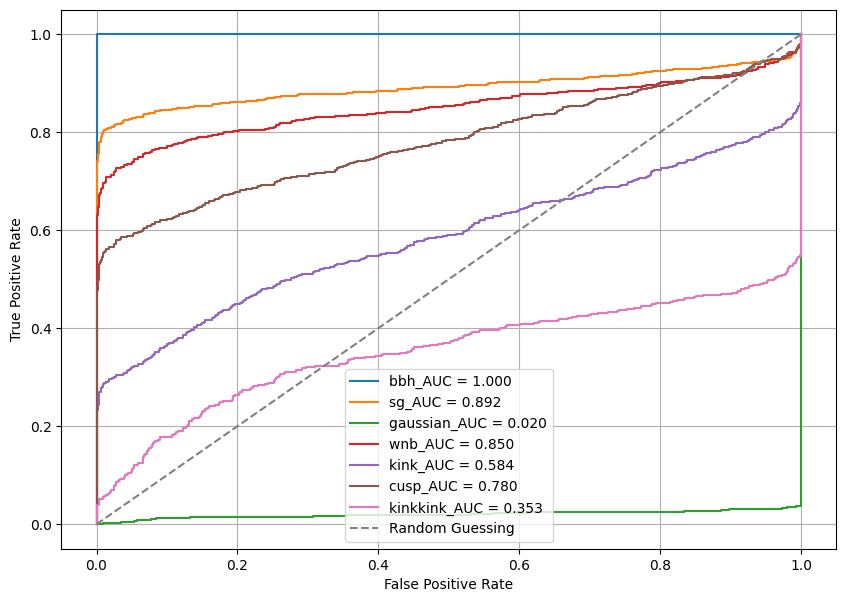


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-41.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


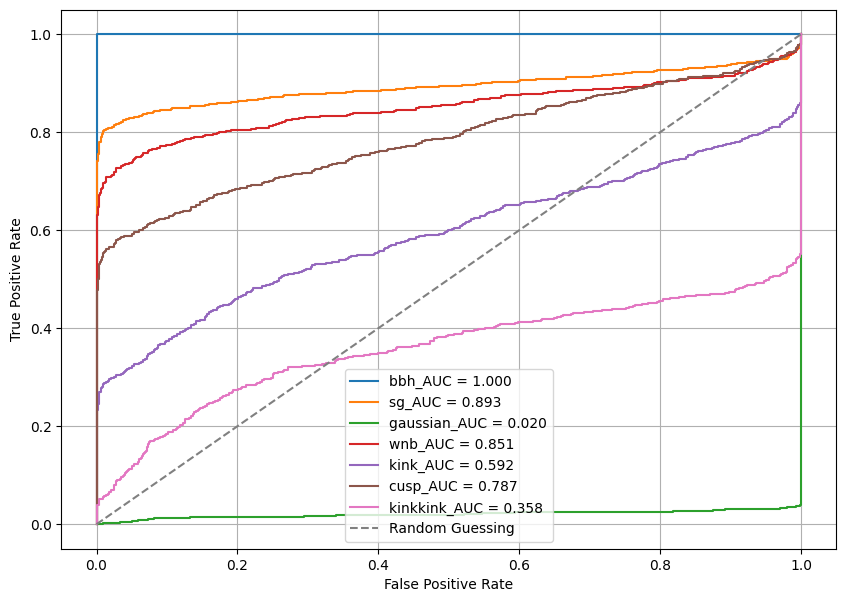


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-42.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


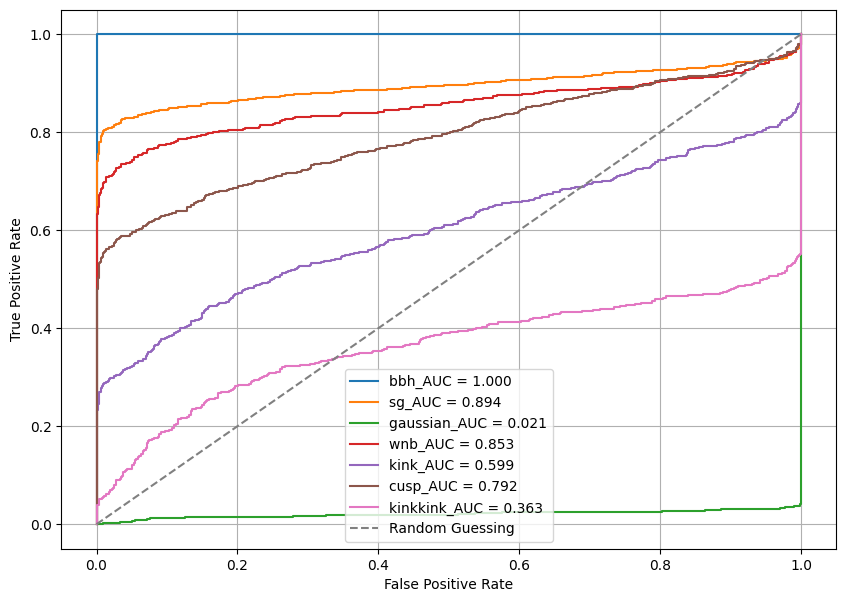


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-43.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


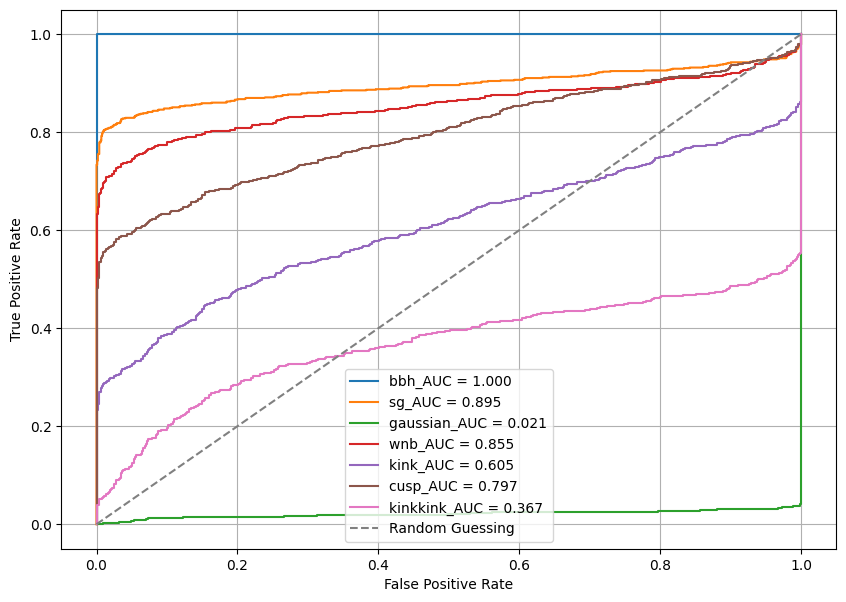


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-44.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


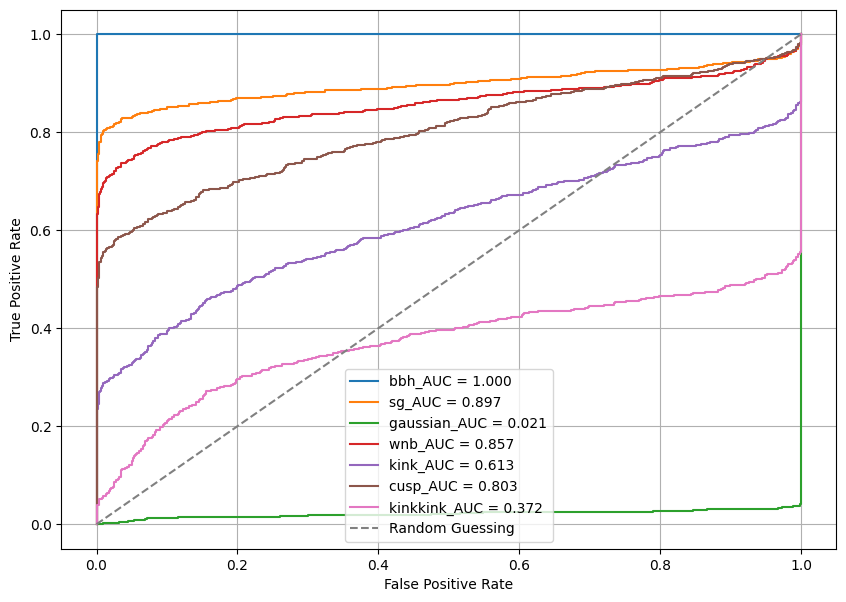


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-45.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


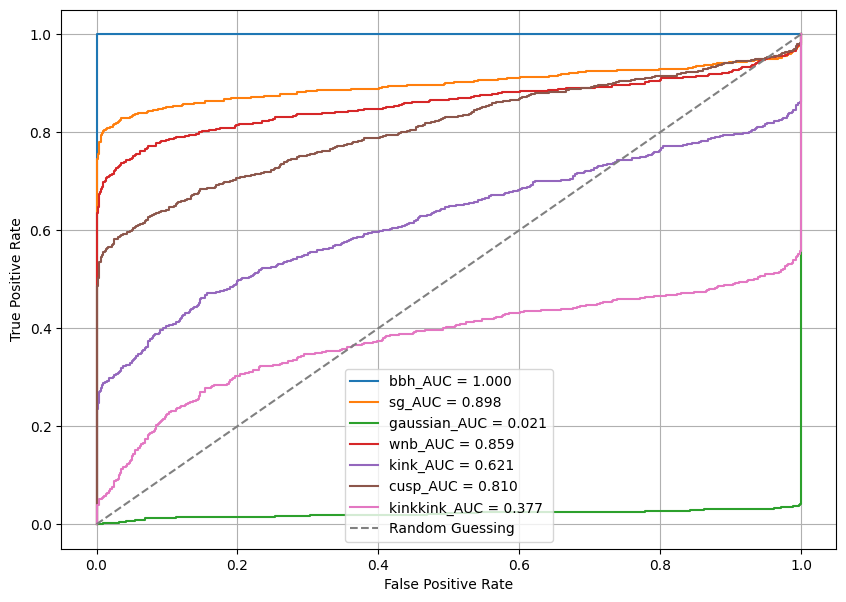


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-46.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


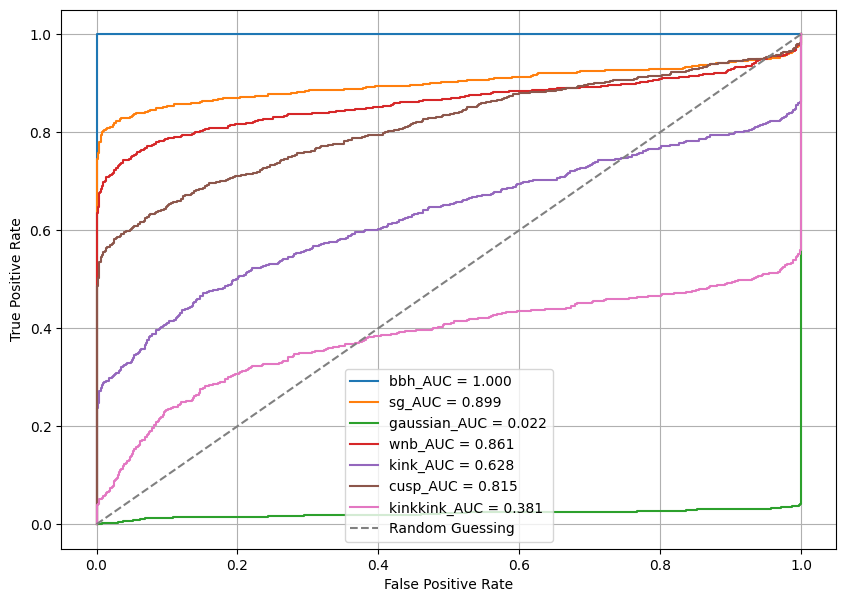


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-47.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


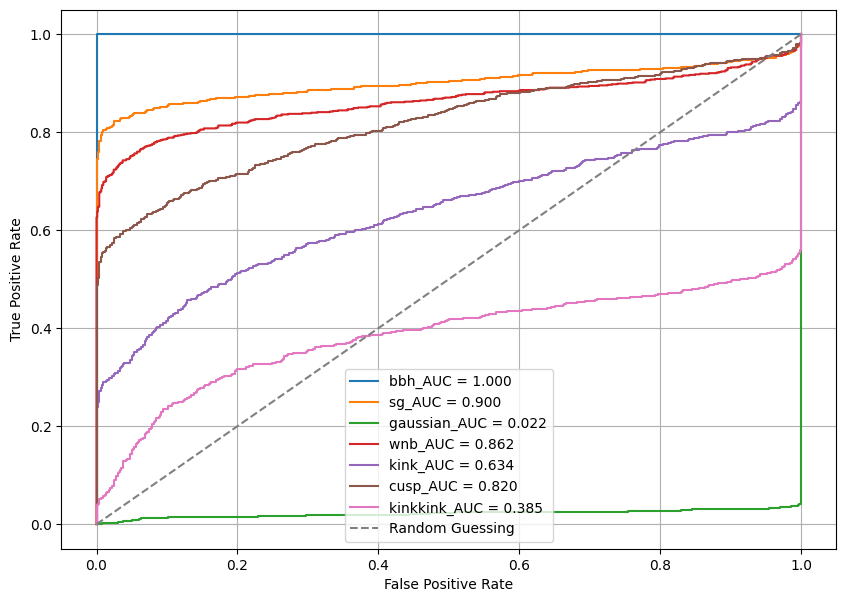


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-48.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


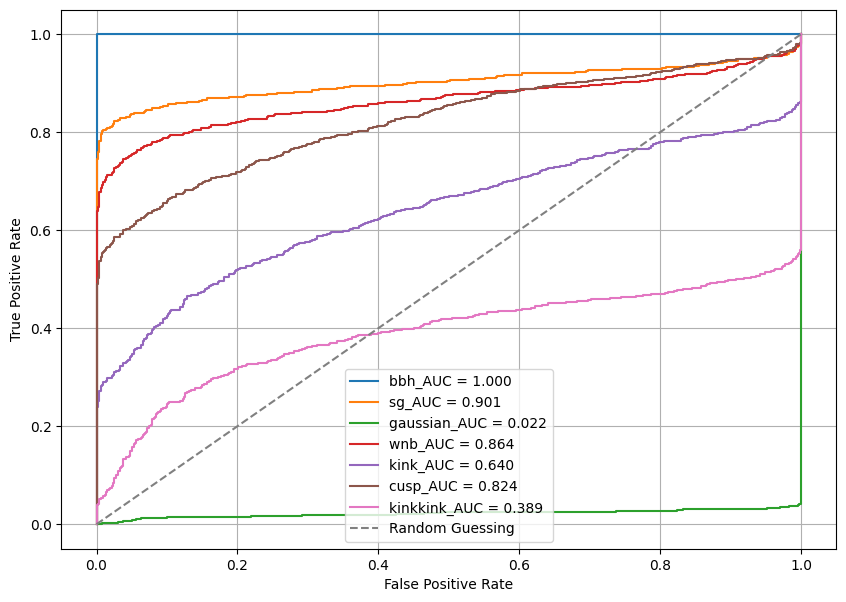


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-49.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


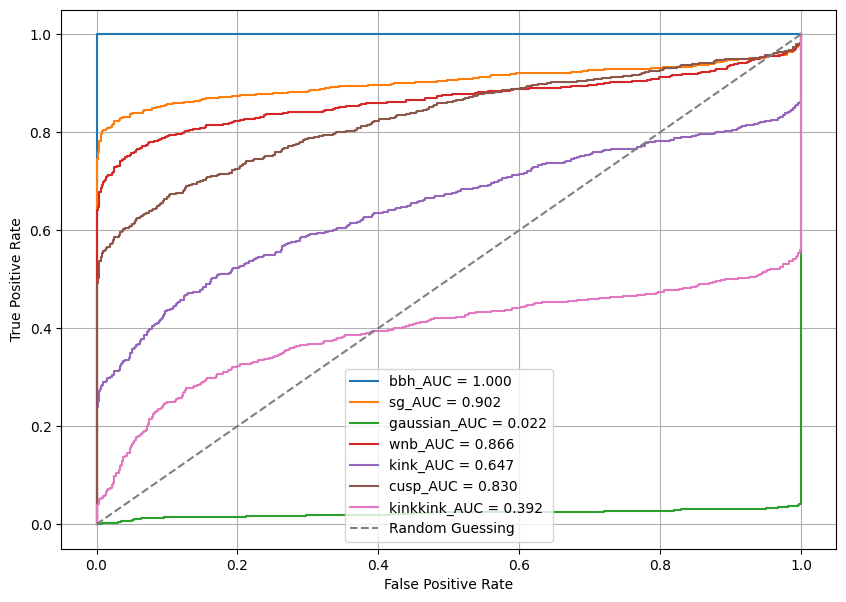


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-50.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


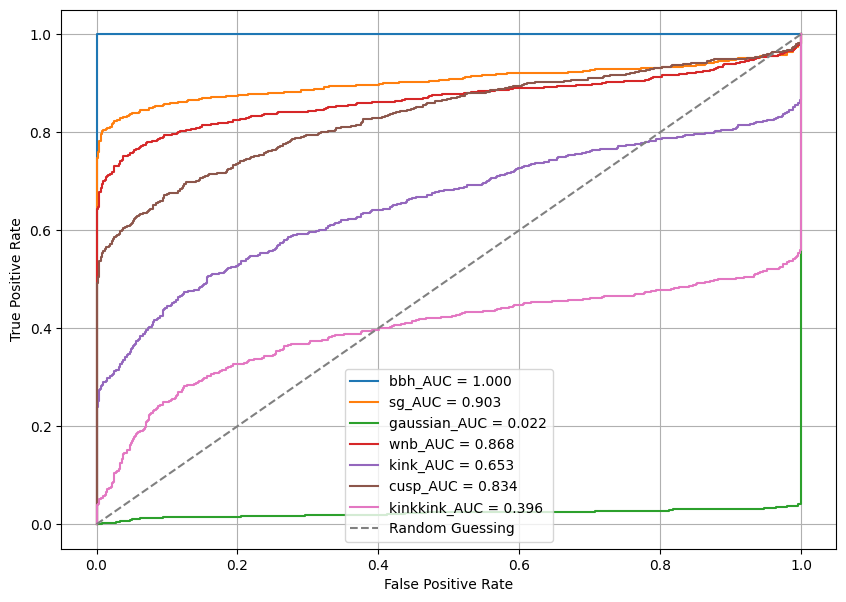


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-51.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


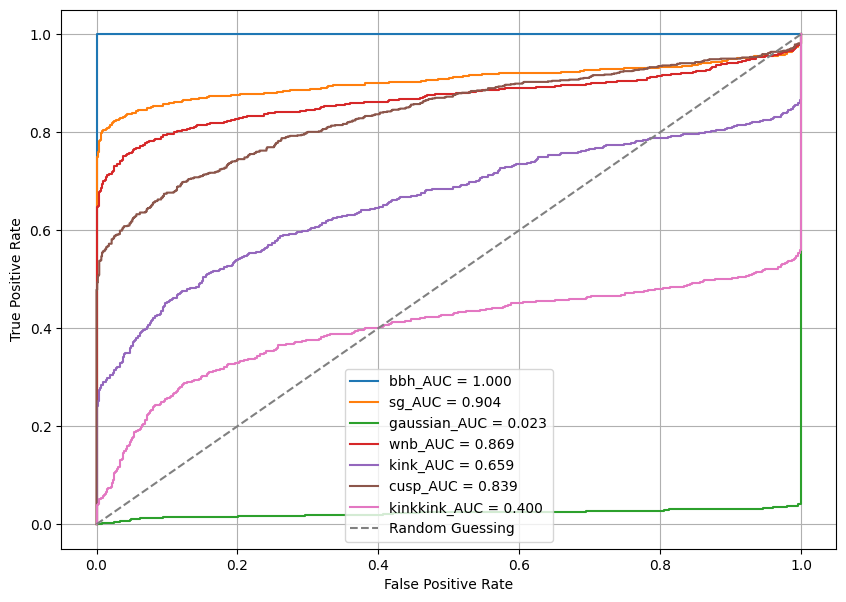


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-52.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


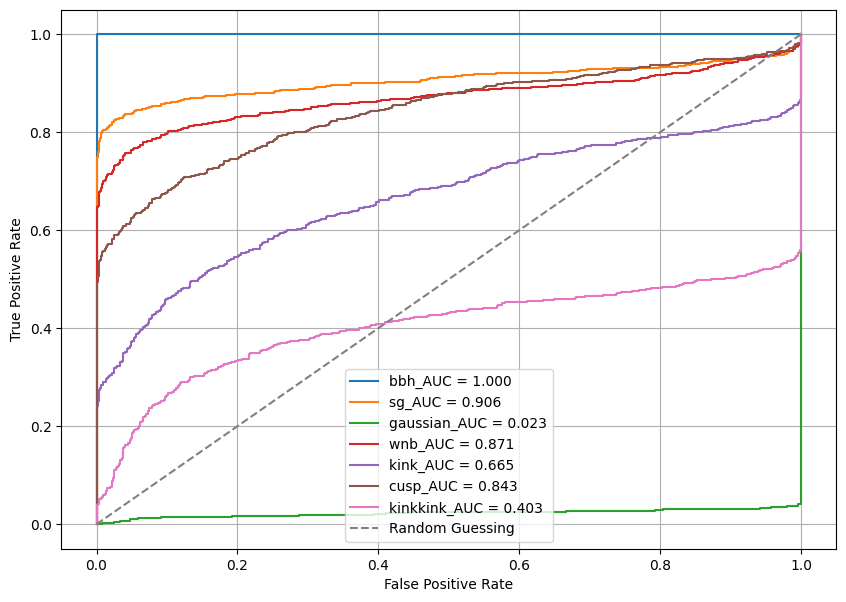


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-53.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


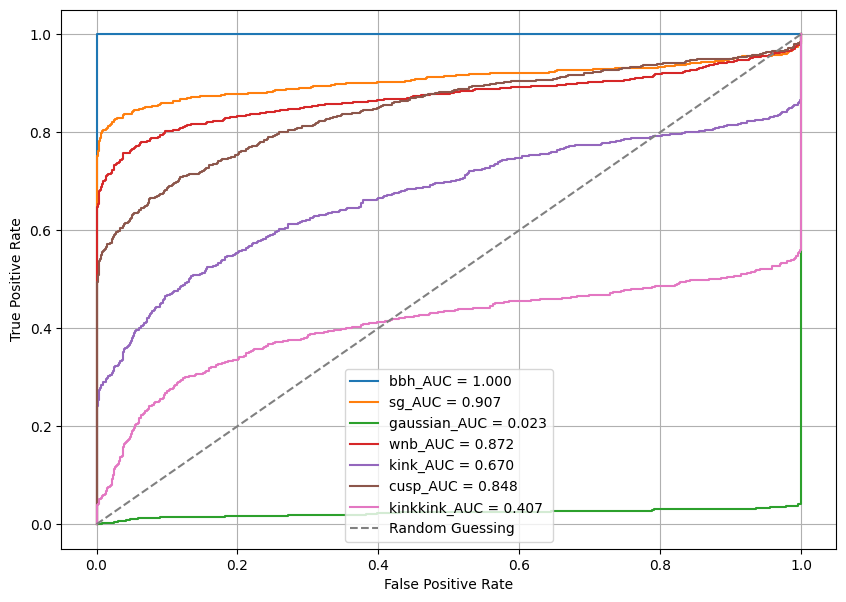


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-54.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


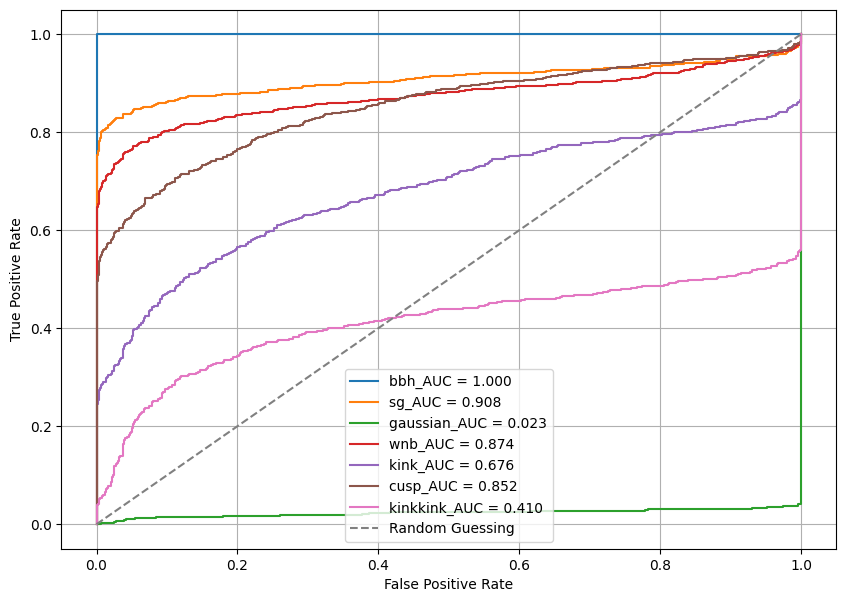


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-55.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


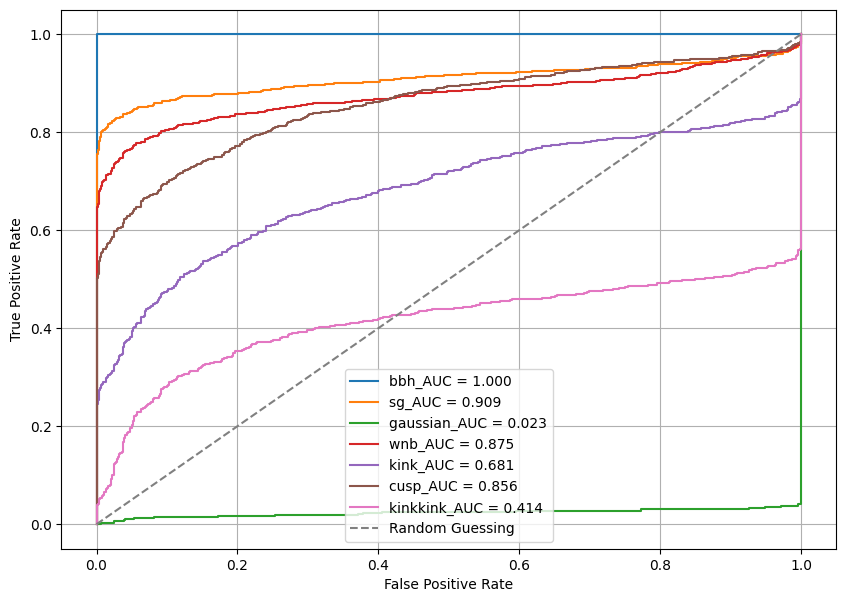


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-56.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


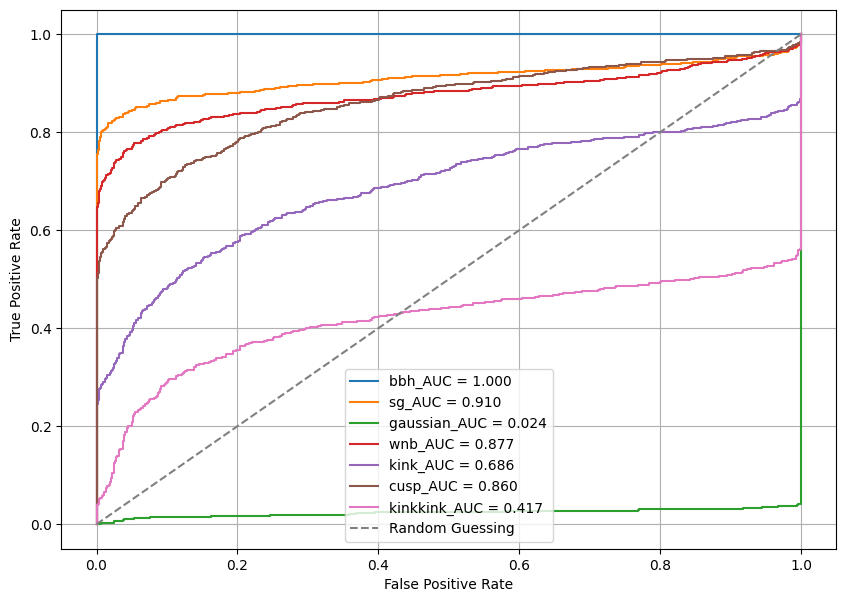


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-57.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


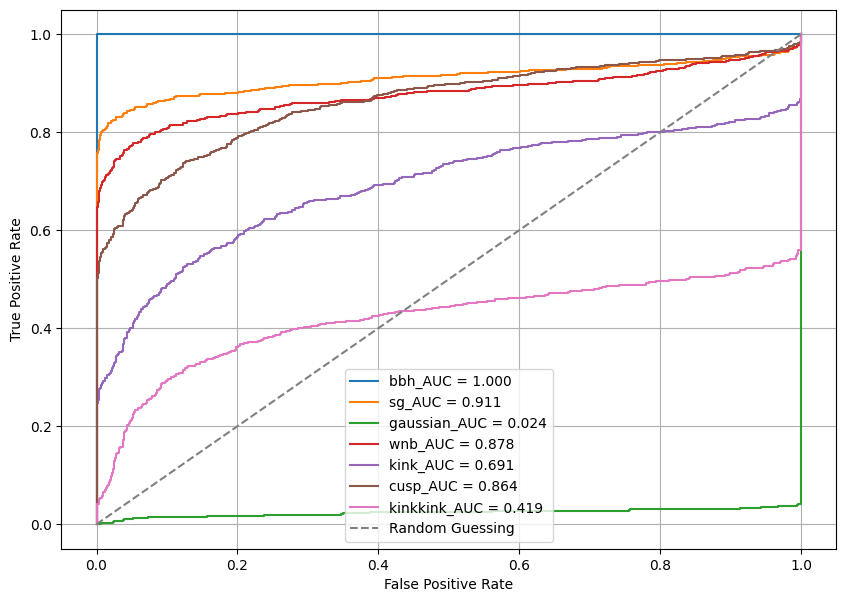


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-58.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


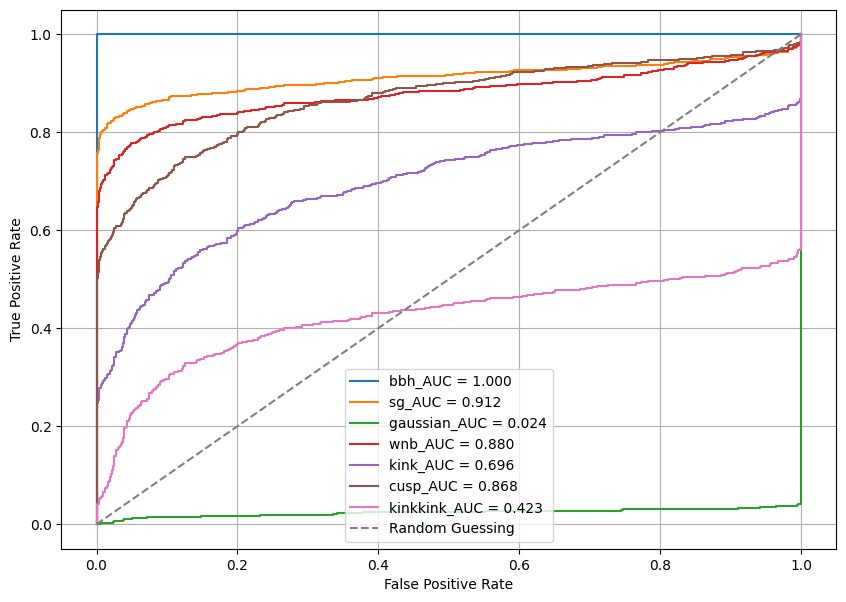


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-59.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


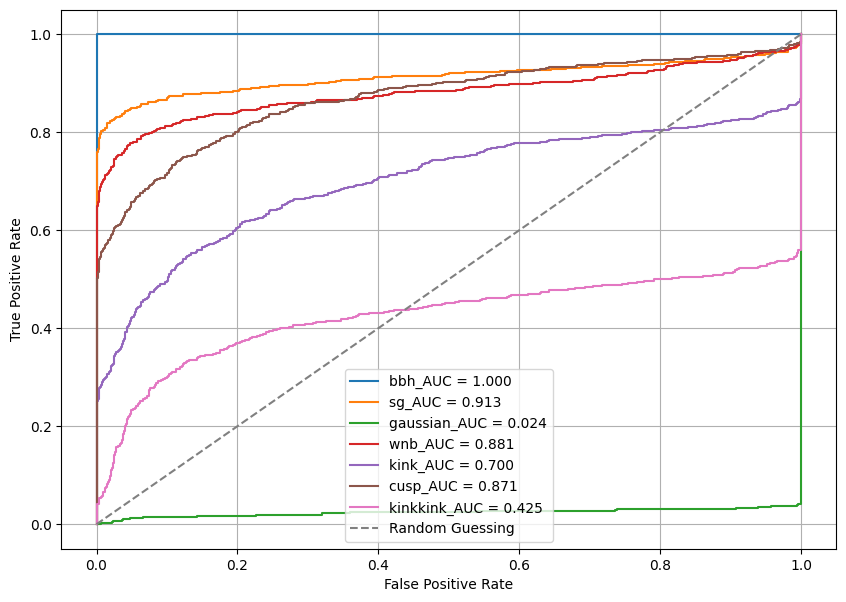


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-60.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


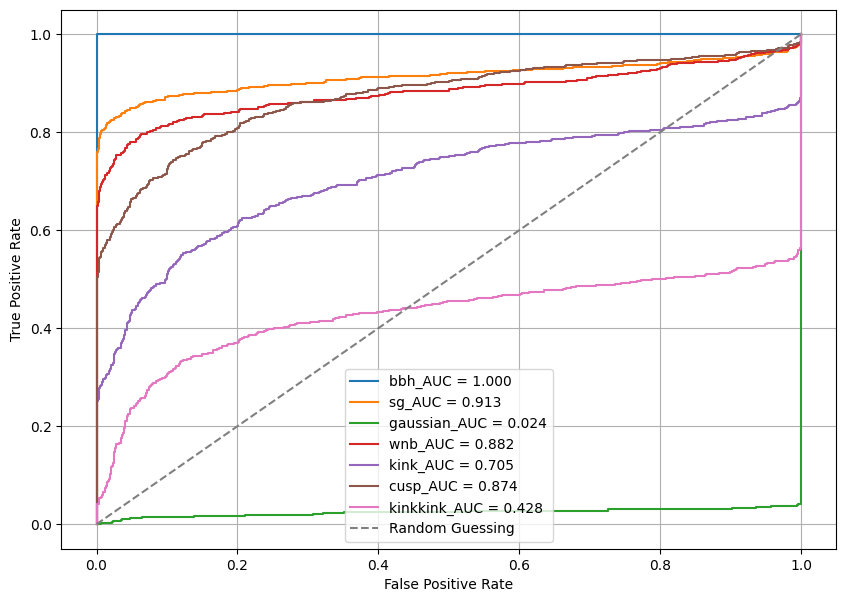


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-61.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


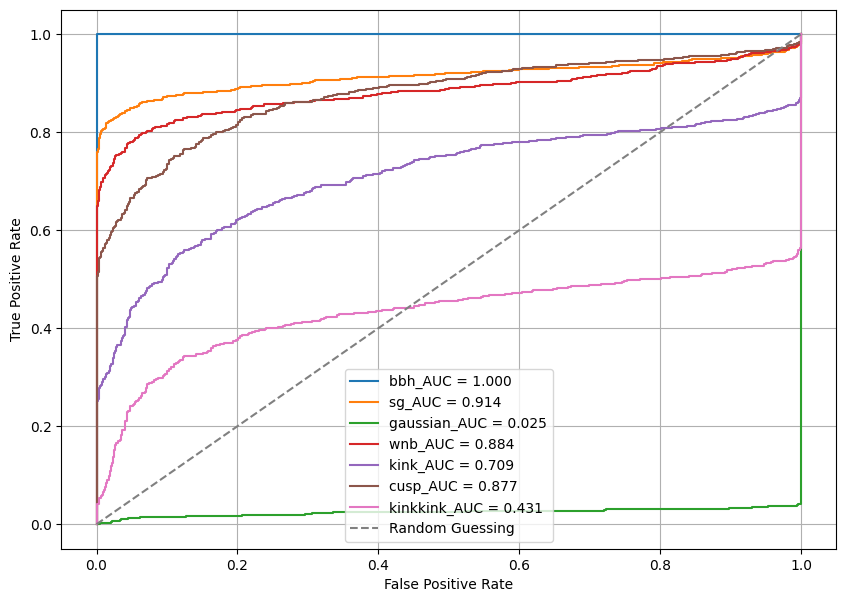


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-62.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


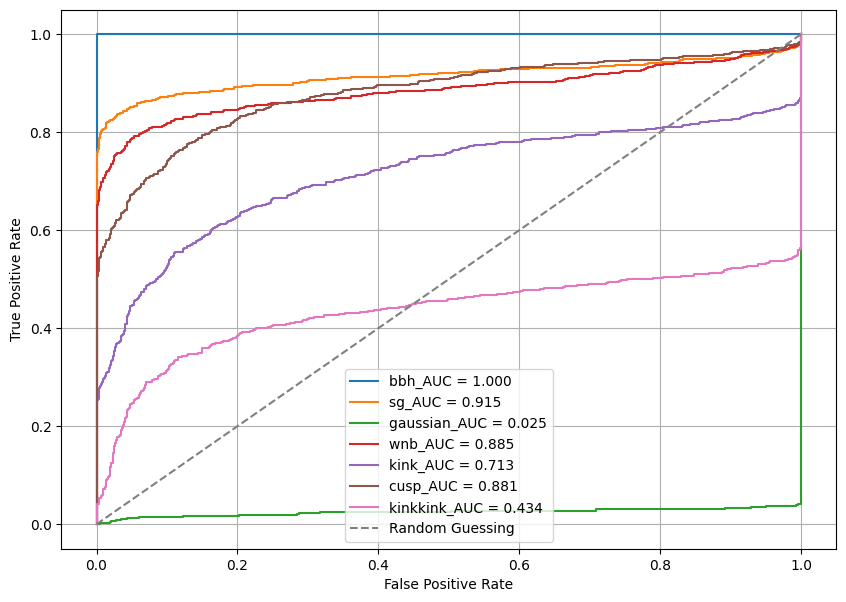


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-63.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


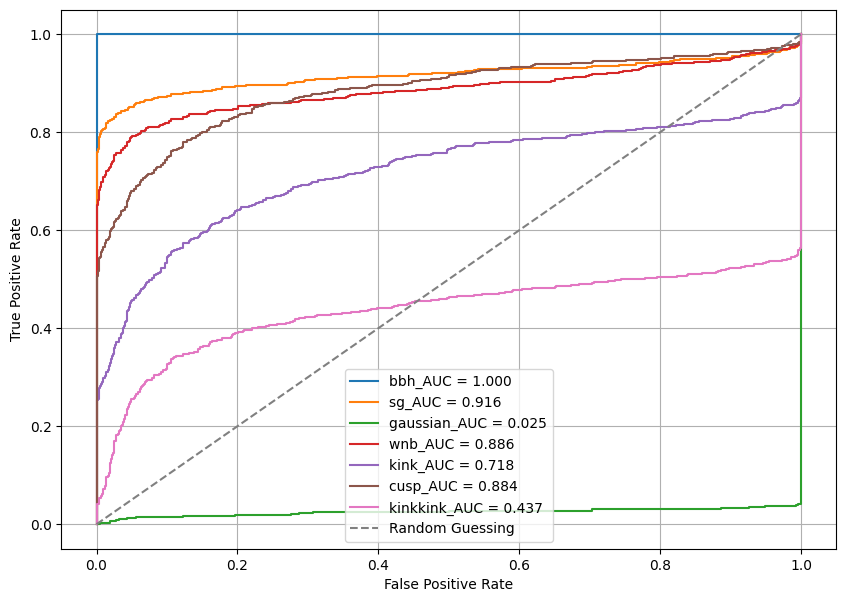


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-64.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


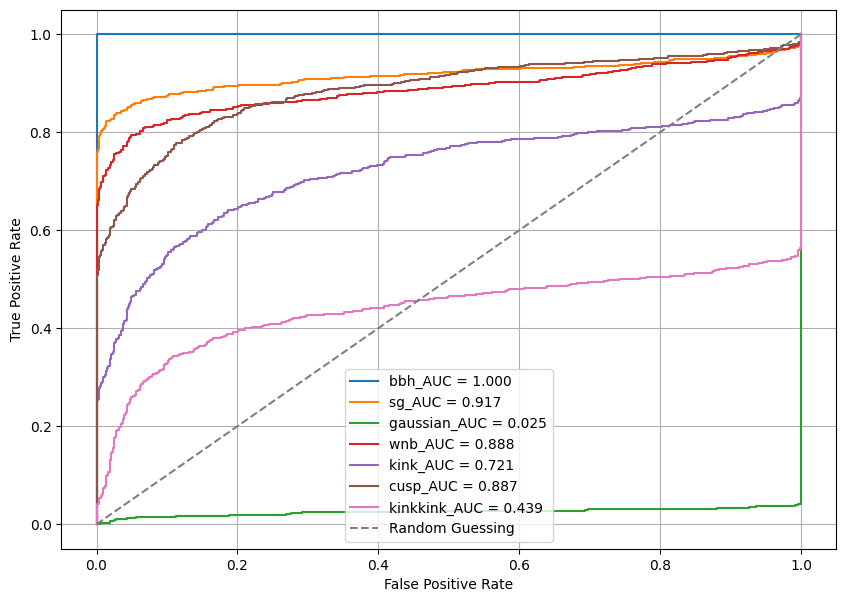


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-65.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


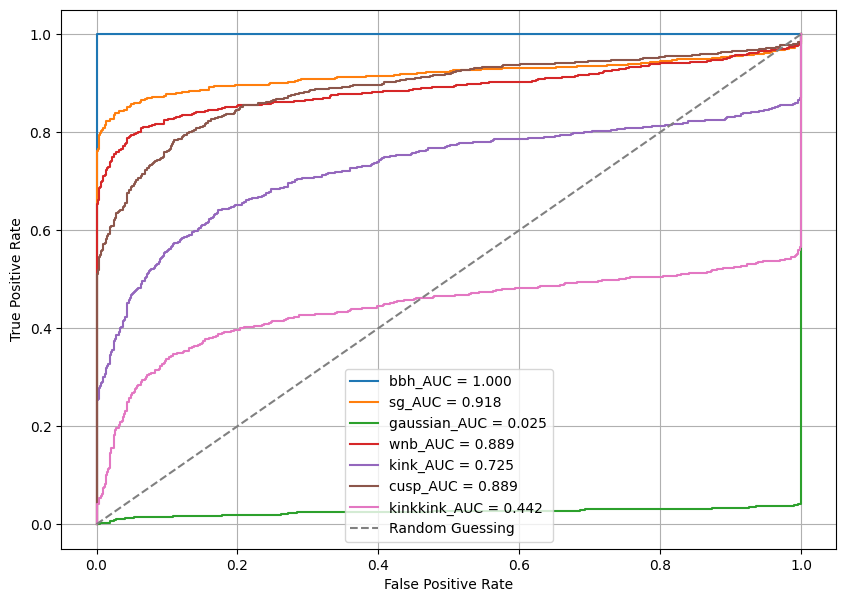


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-66.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


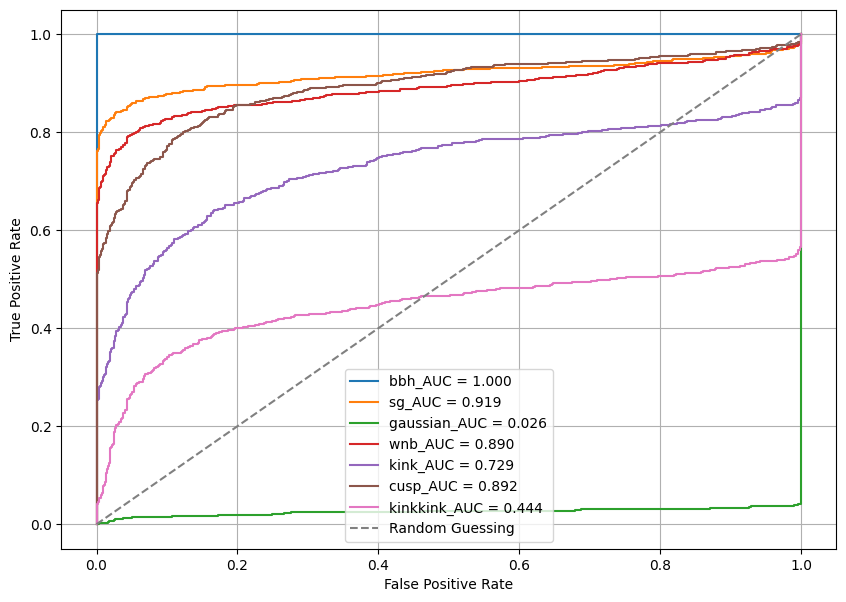


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-67.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


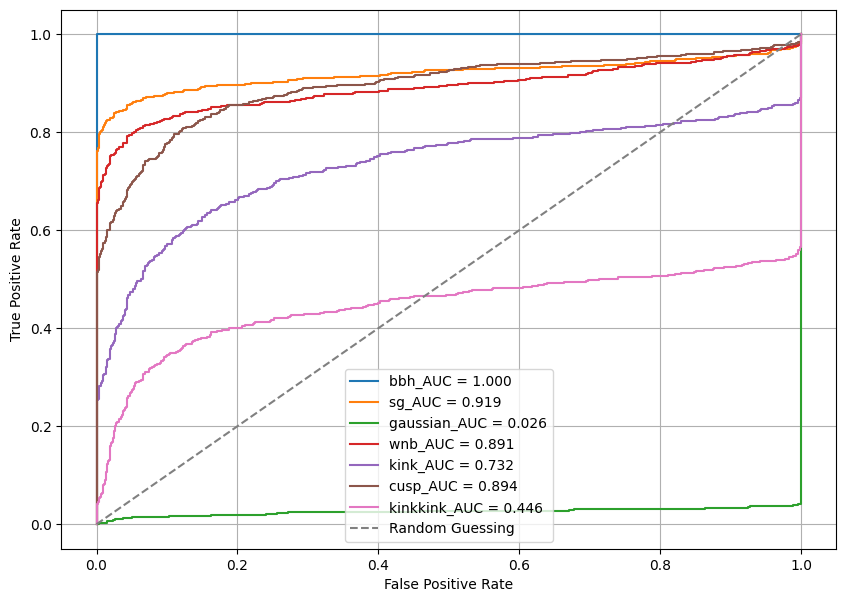


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-68.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


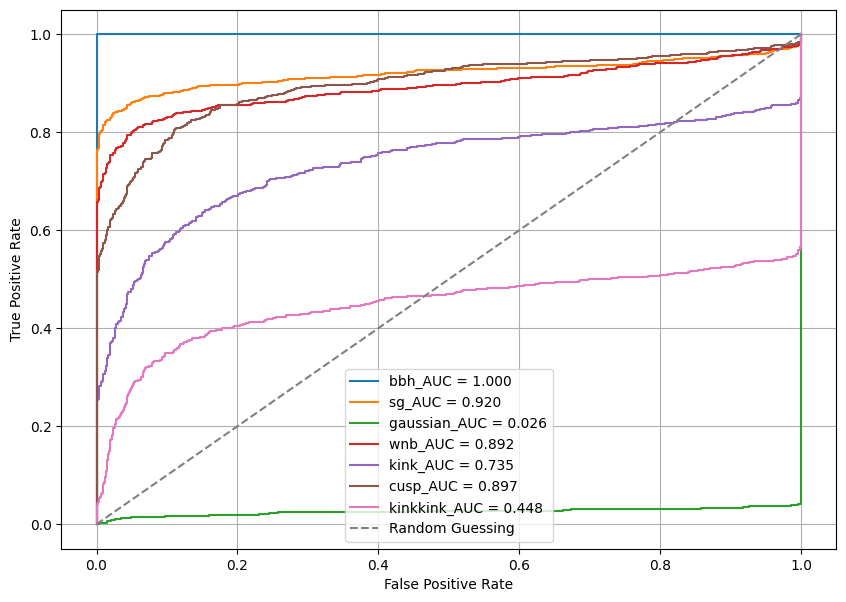


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-69.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


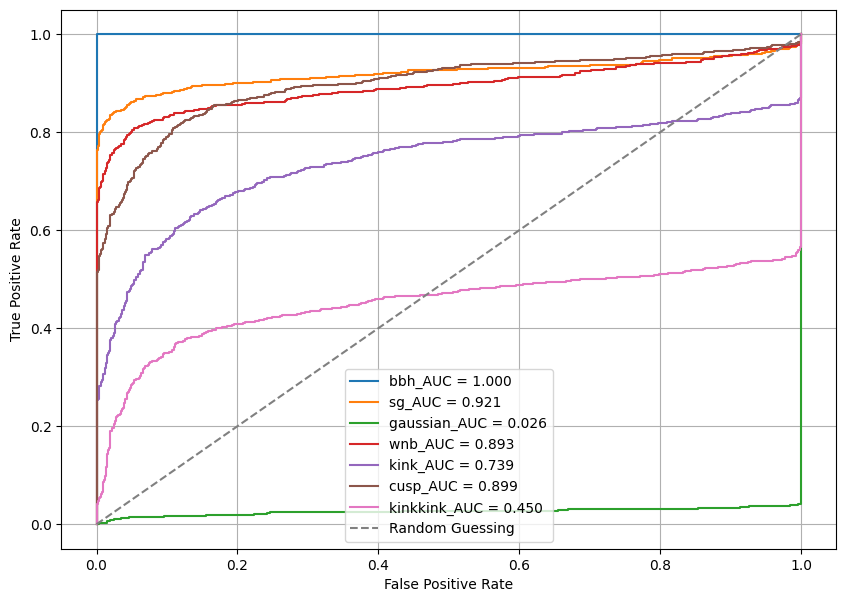


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-70.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


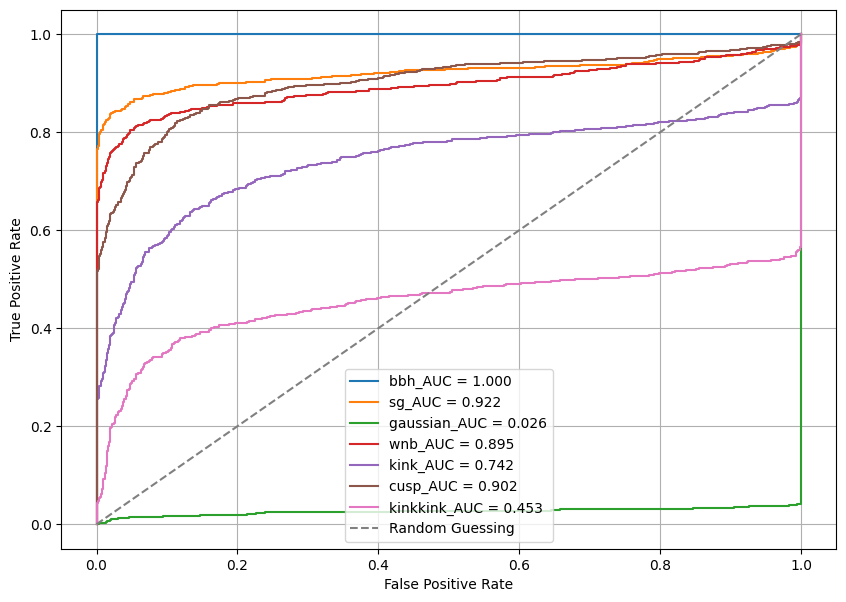


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-71.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


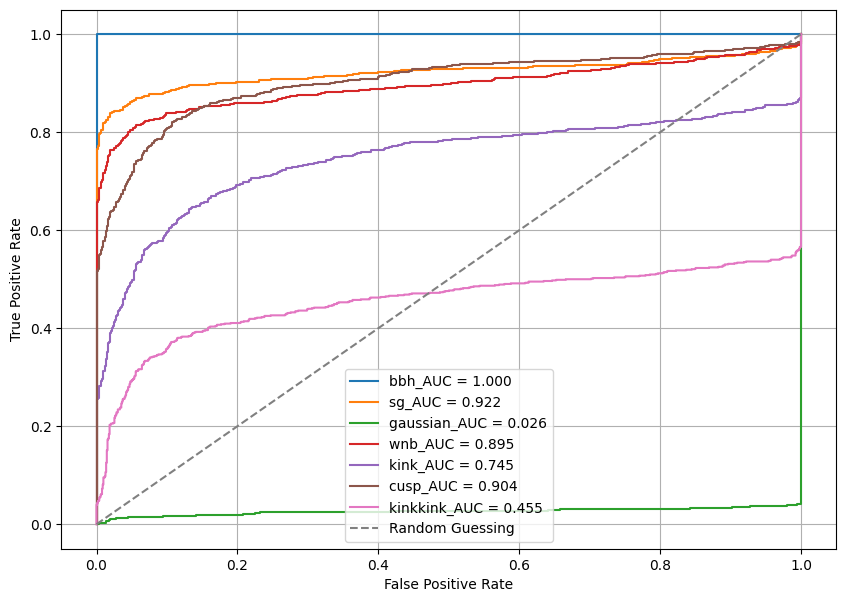


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-72.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


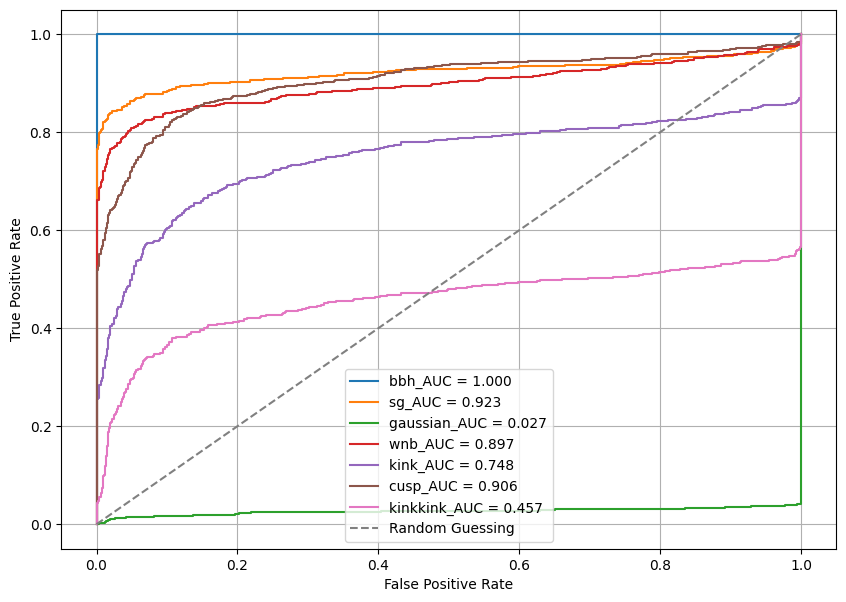


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-73.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


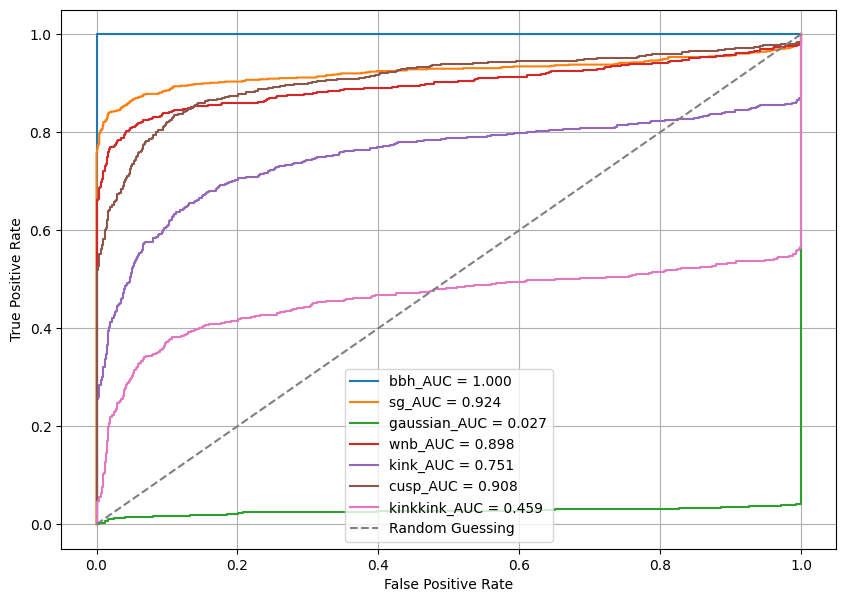


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-74.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


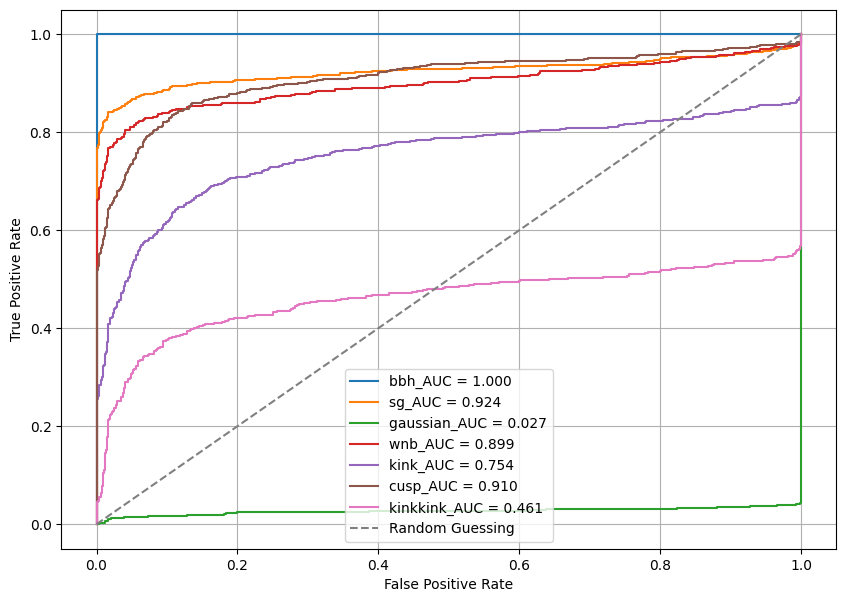


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-75.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


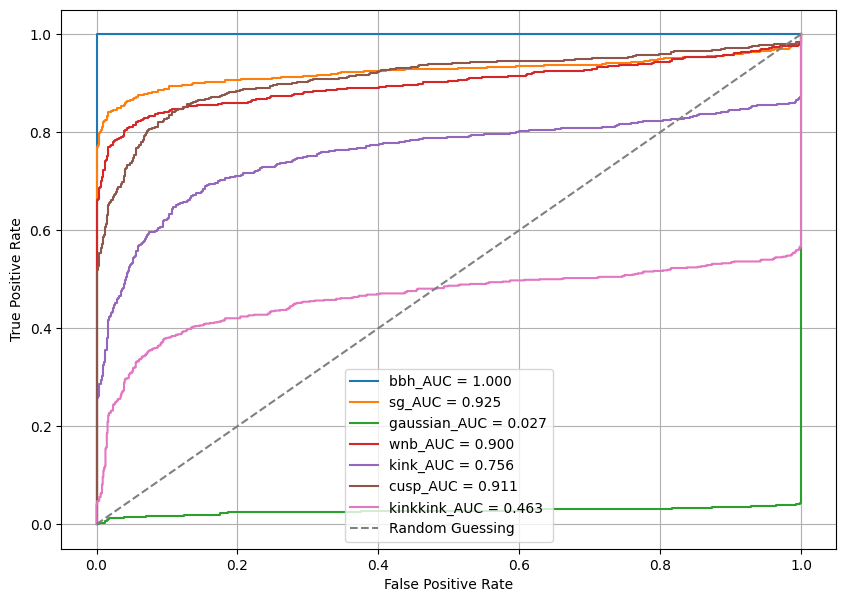


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-76.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


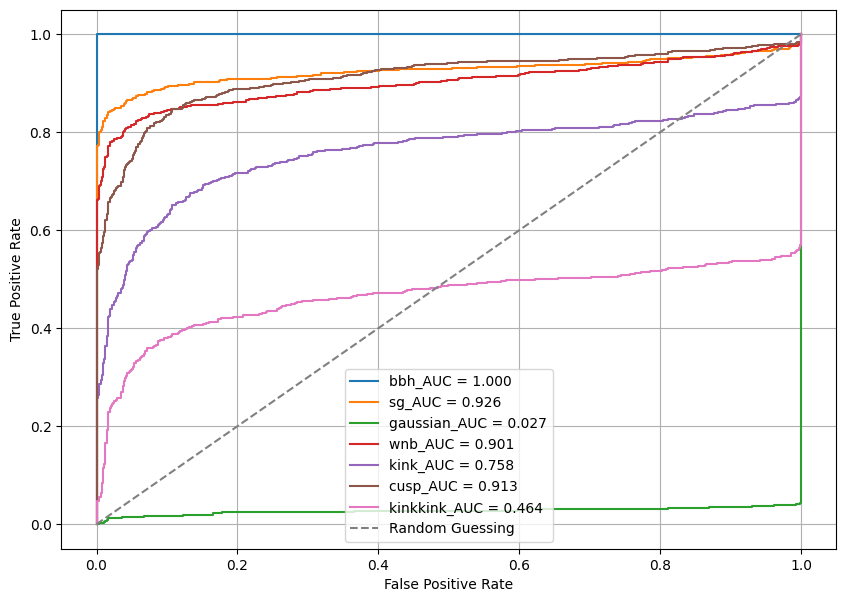


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-77.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


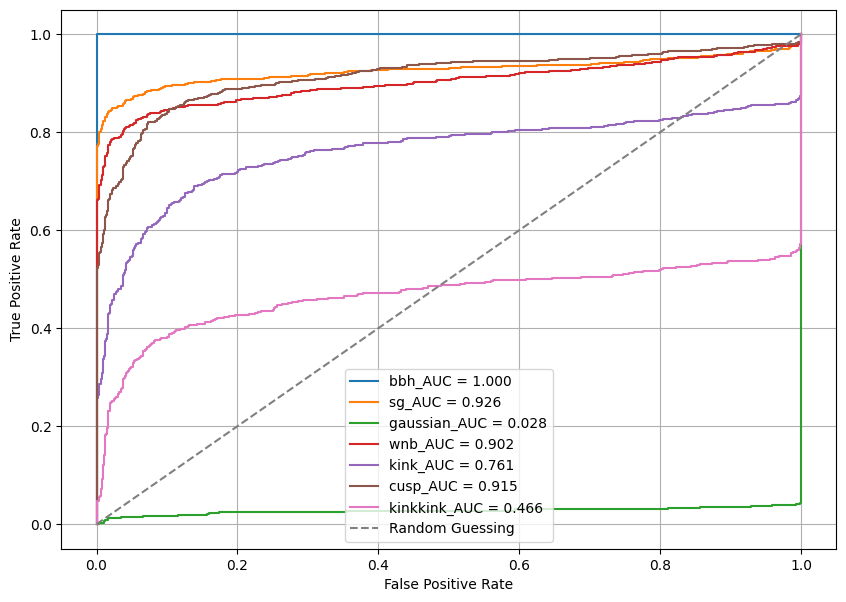


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-78.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


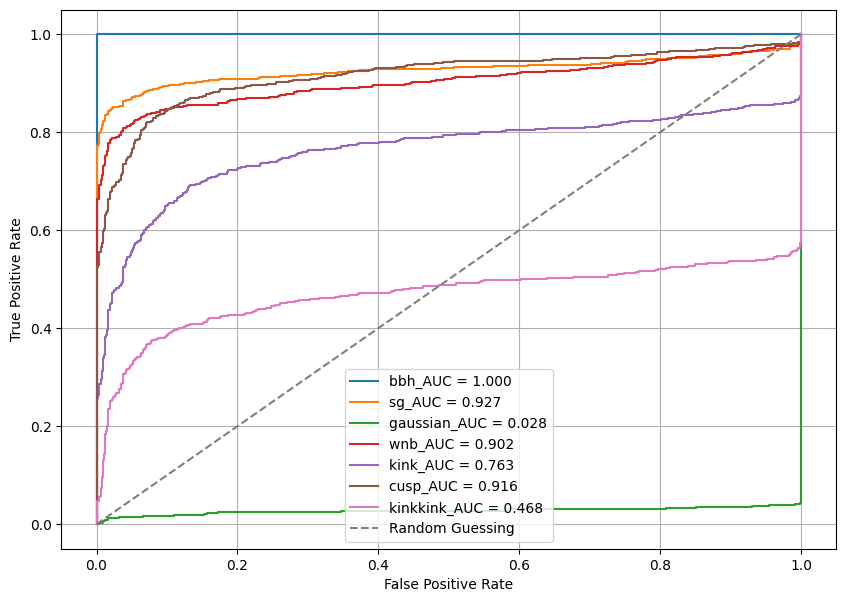


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-79.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


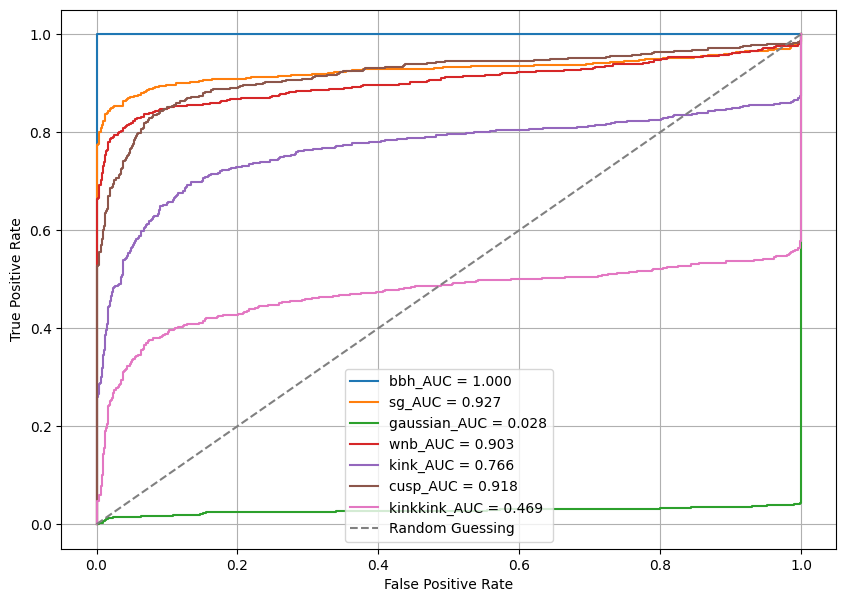


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-80.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


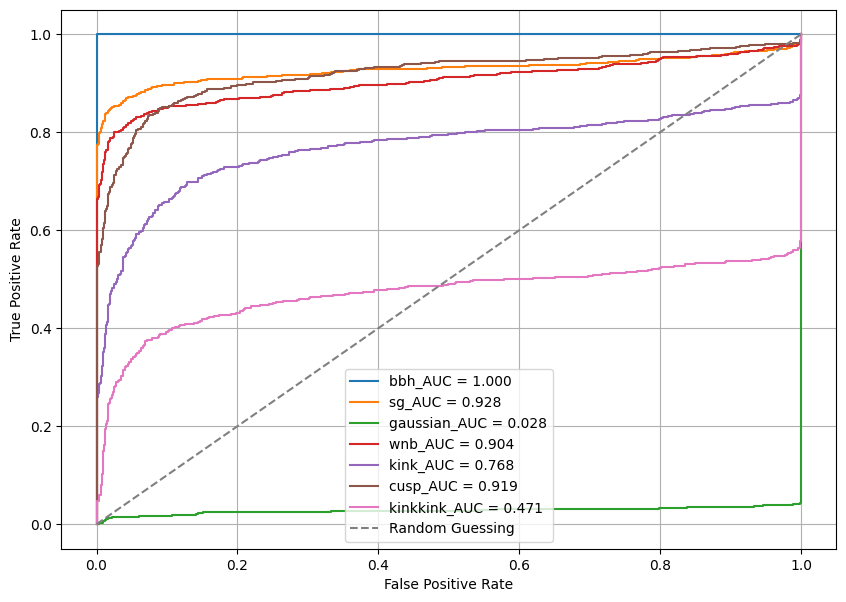


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-81.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


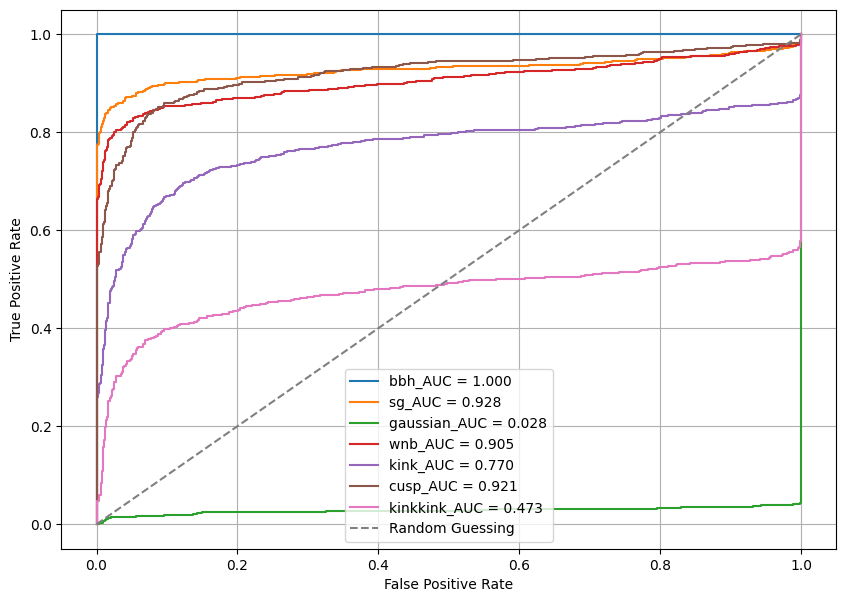


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-82.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


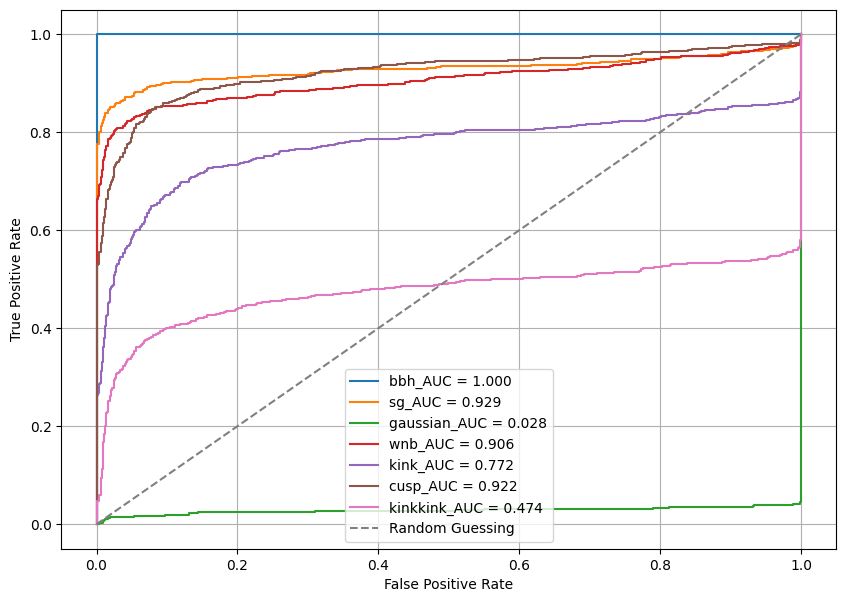


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-83.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


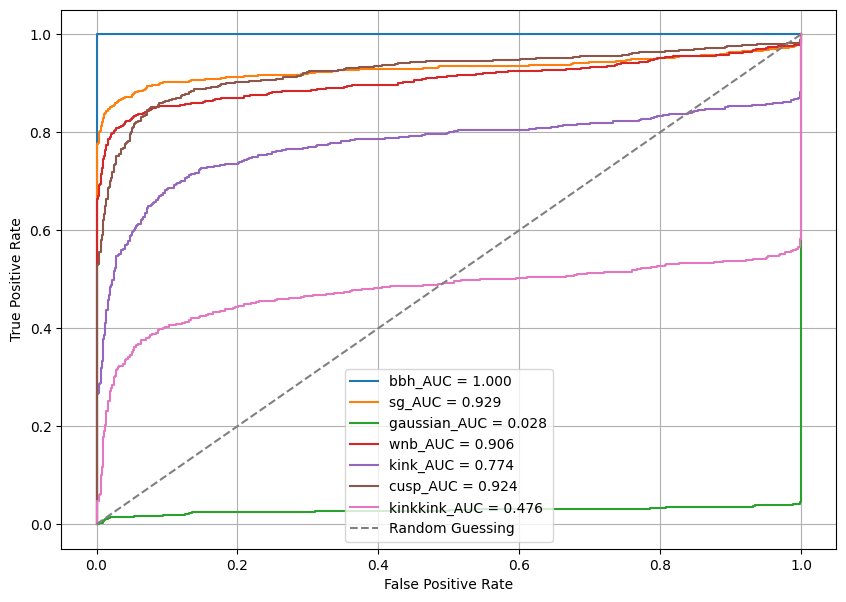


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-84.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


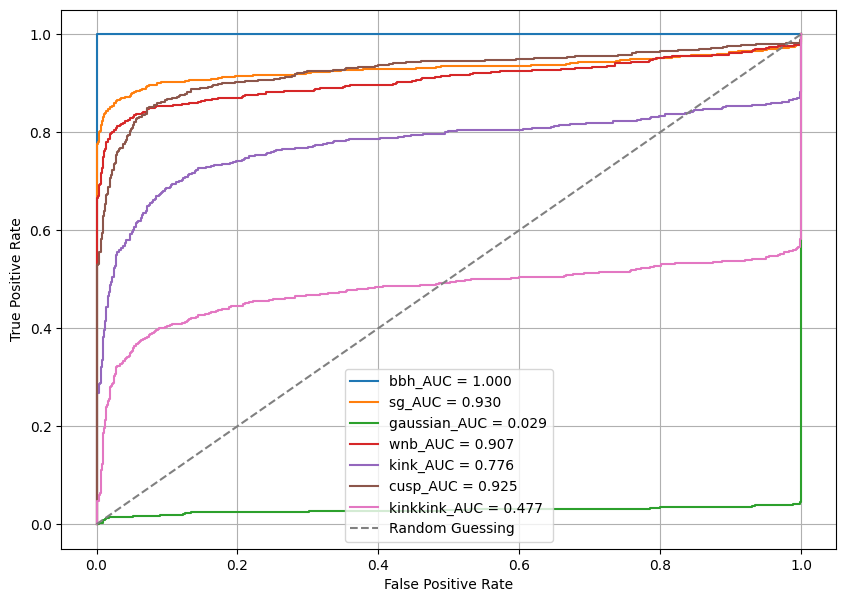


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-85.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


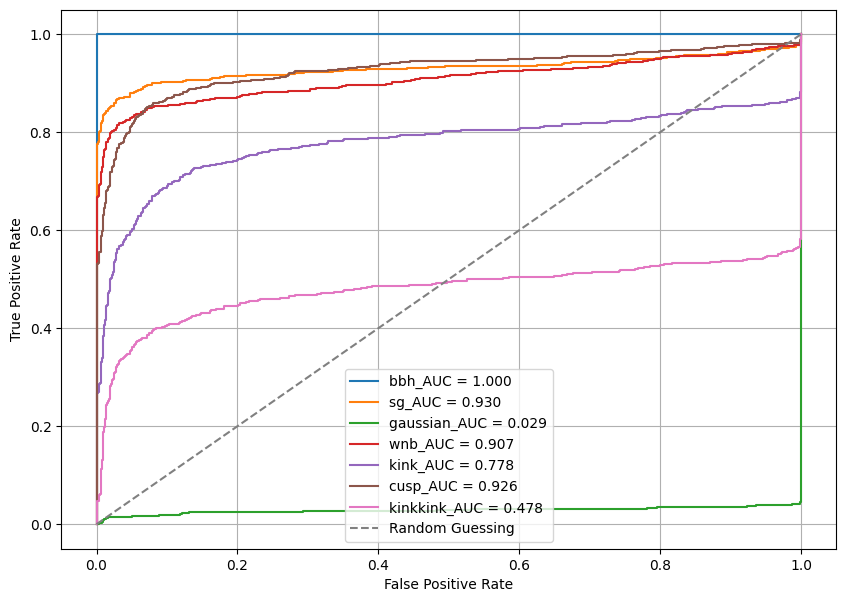


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-86.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


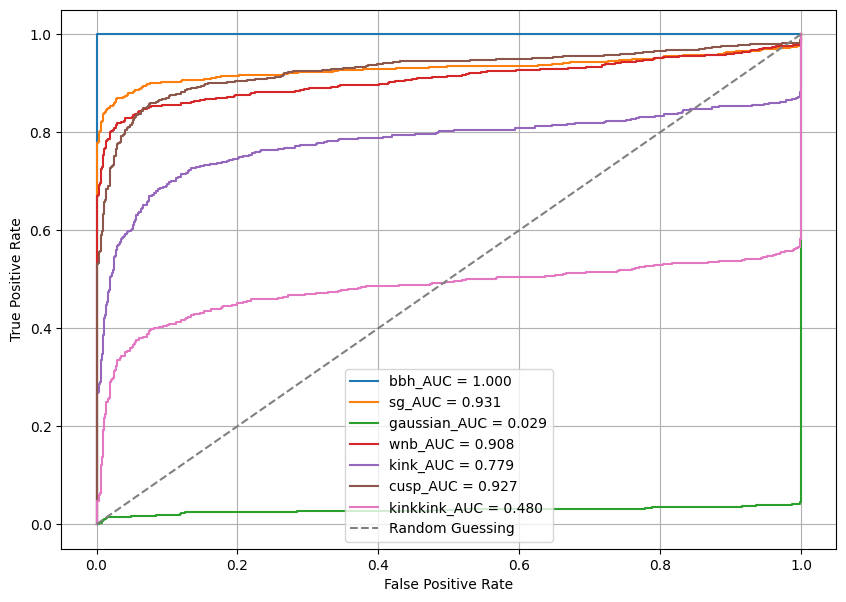


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-87.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


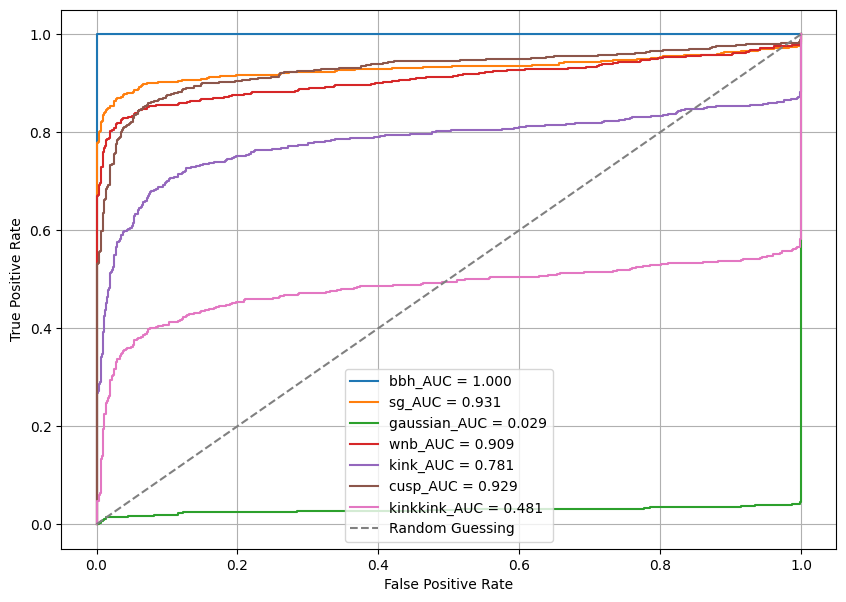


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-88.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


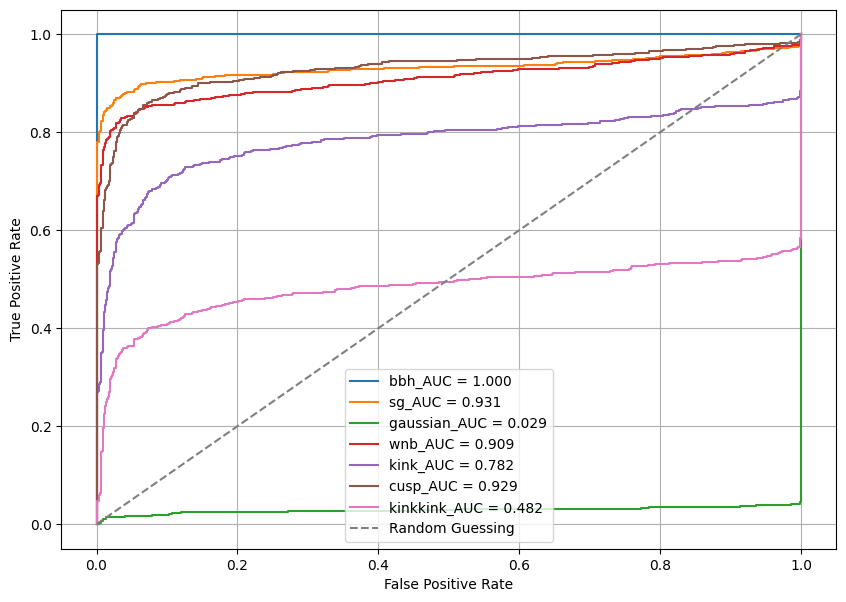


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-89.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


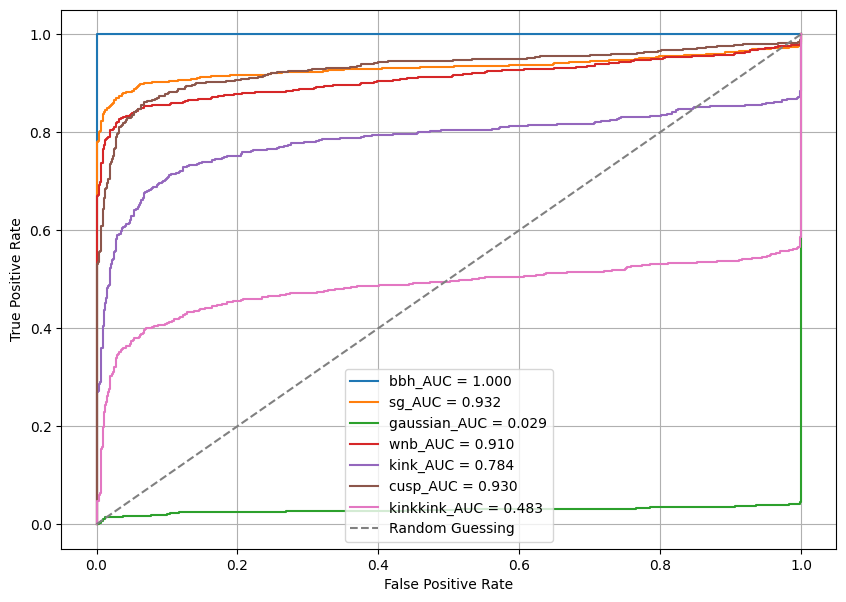


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-90.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


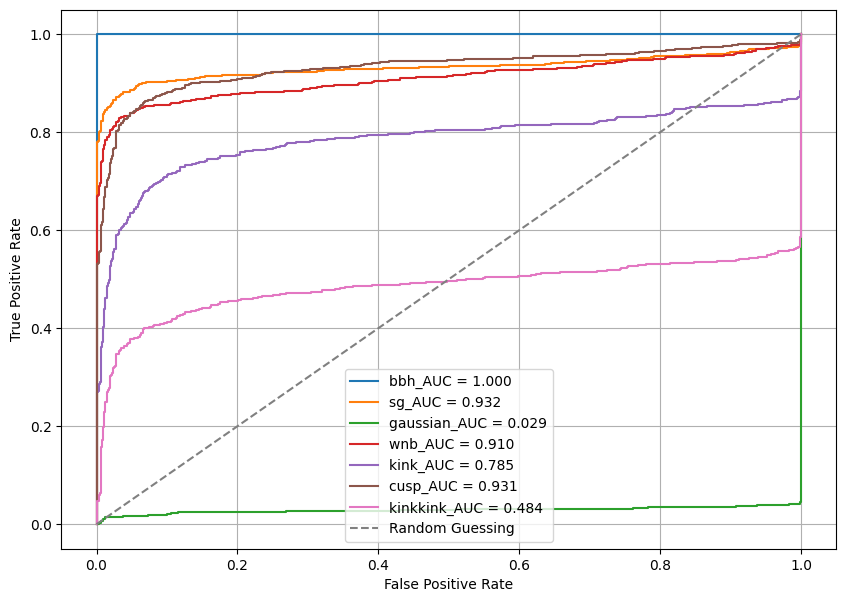


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-91.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


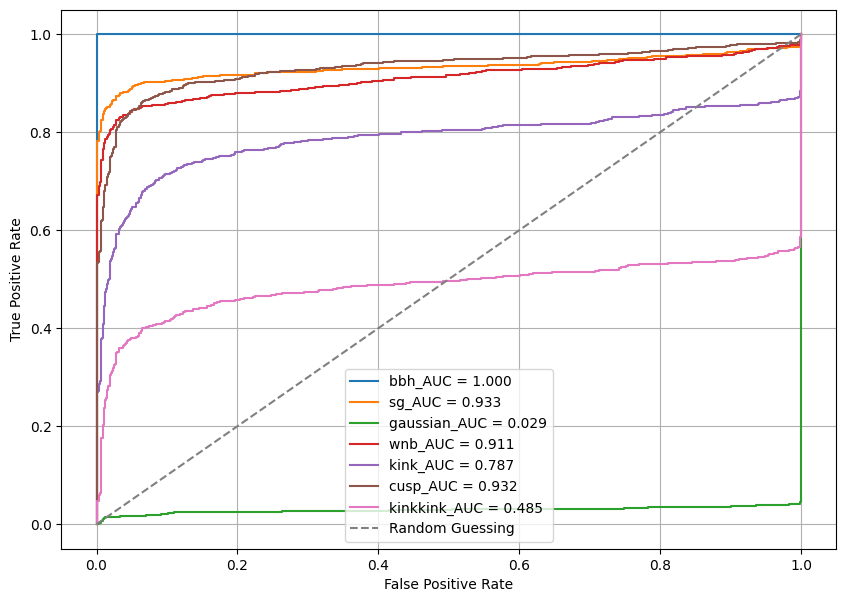


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-92.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


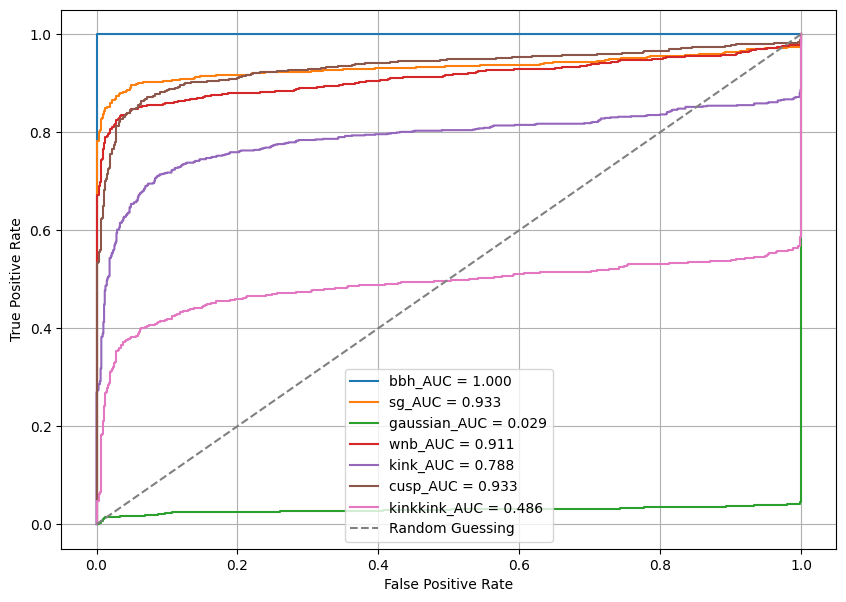


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-93.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


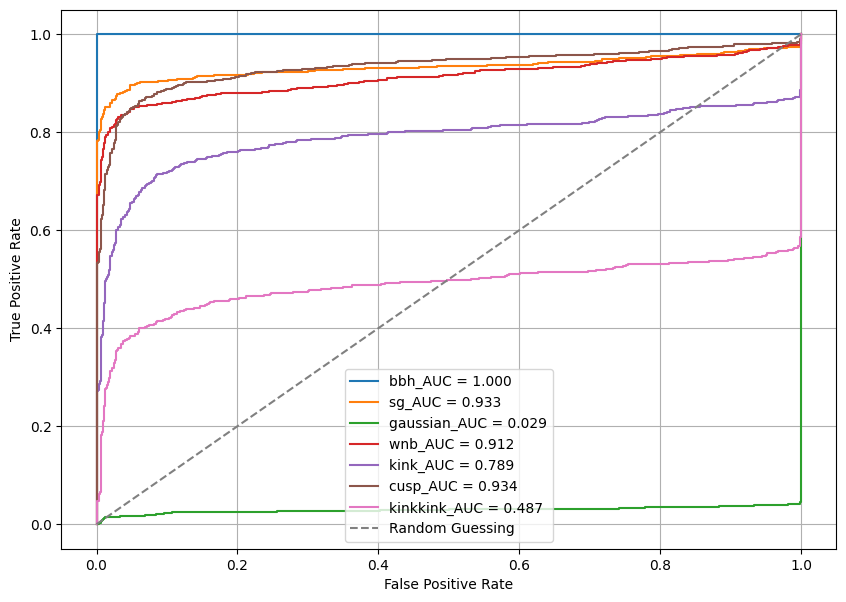


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-94.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


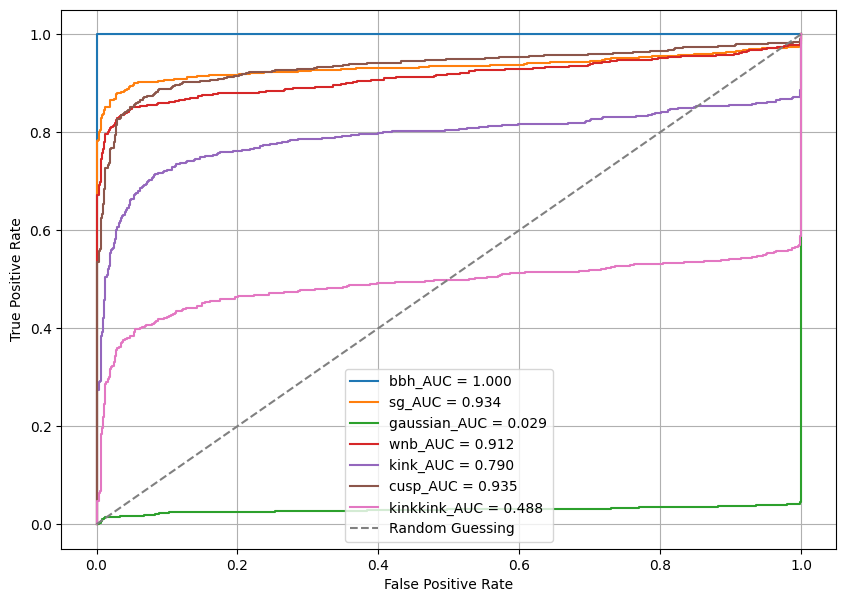


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-95.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


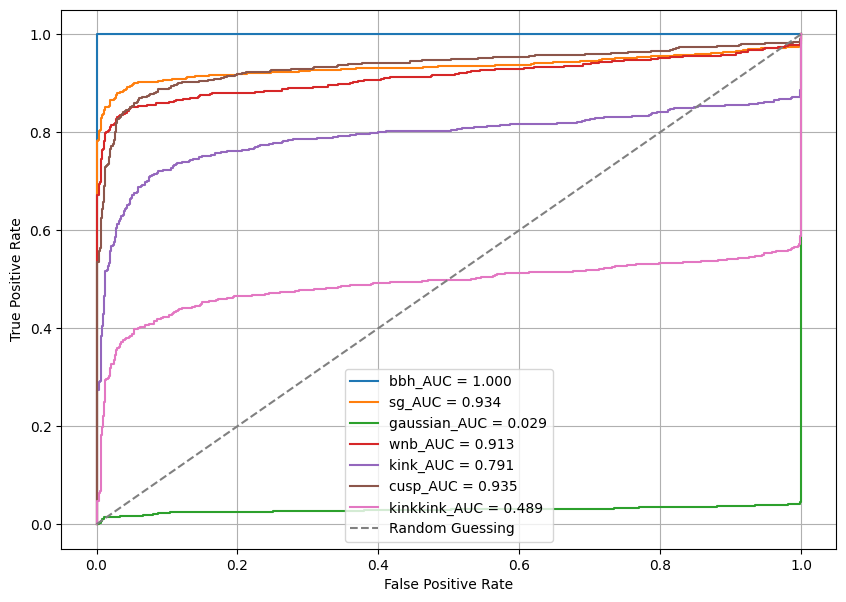


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-96.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


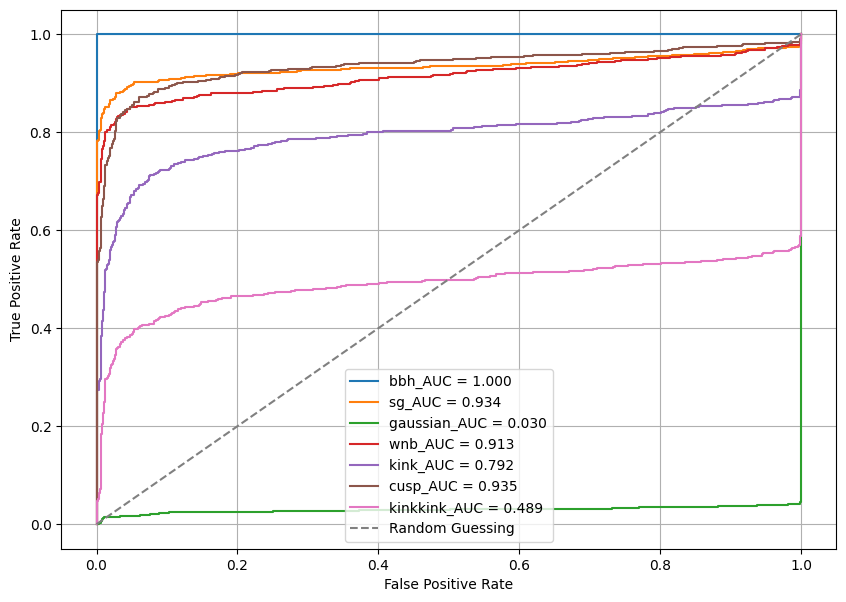


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-97.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


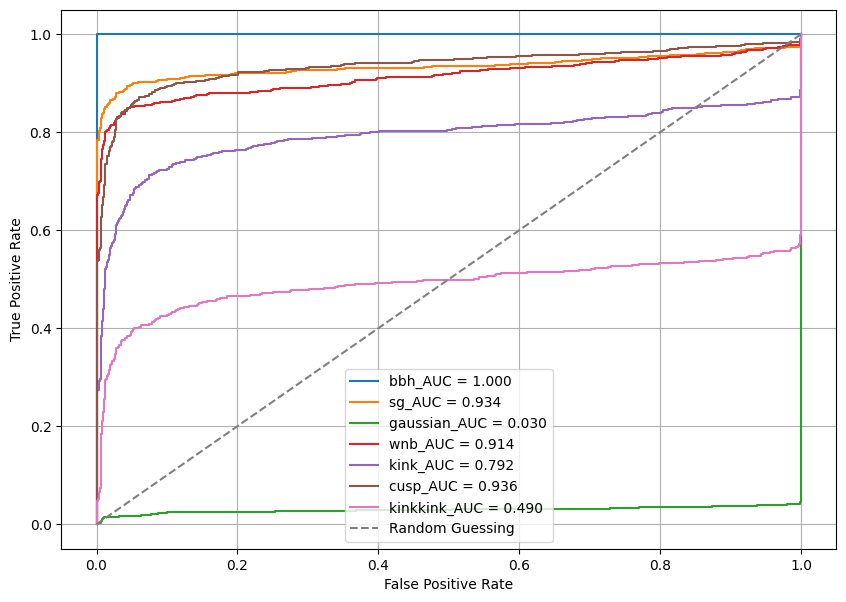


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-98.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


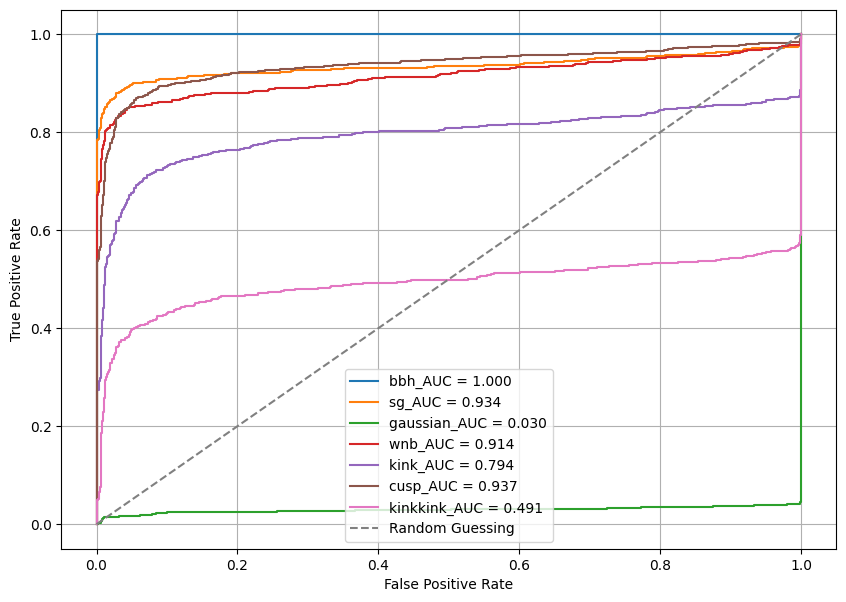


Evaluating model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-99.keras...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


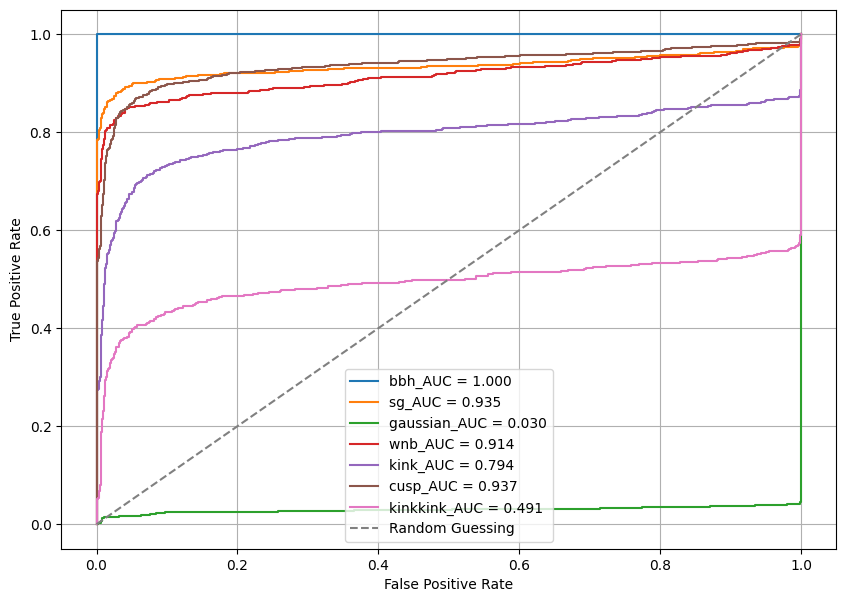


Top models by mean AUC:
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-107.keras: Mean AUC = 0.7299
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-111.keras: Mean AUC = 0.7299
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-112.keras: Mean AUC = 0.7299
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-104.keras: Mean AUC = 0.7299
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-109.keras: Mean AUC = 0.7298
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-32_f4-128_k1-4_k2-8_k3-16_k4-32_lr-1e-05_s1-1_s2-2_s3-2_s4-1_epoch-108.keras: Mean AUC = 0.7298
model_batch_size-900_dropout-0.1_epochs-120_f1-3_f2-8_f3-

In [132]:
# Path where your models are saved

model_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'
model_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.keras')])

# Test data
auc_results = []

for model_file in model_files:
    print(f"\nEvaluating {model_file}...")
    model = tf.keras.models.load_model(os.path.join(model_dir, model_file))

    bbh_auc, sglf_auc, gaussian_auc, WNb_auc, kinks_auc, kinkkink_auc, cusps_auc = eval(model, background_test, BBH, SG, Gaussian, WNB, Kink, Cusp, KinkKink)
    auc_list = [bbh_auc, sglf_auc, gaussian_auc, WNb_auc, kinks_auc, kinkkink_auc, cusps_auc]

    mean_auc = np.mean(auc_list)
    auc_results.append((model_file, mean_auc))

# Sort by mean AUC
sorted_results = sorted(auc_results, key=lambda x: x[1], reverse=True)

print("\nTop models by mean AUC:")
for fname, mean in sorted_results:
    print(f"{fname}: Mean AUC = {mean:.4f}")
